In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# Base de dados

In [3]:
df = pd.read_csv('dengue_sinan.csv', low_memory=False)

In [4]:
display(df)

,NU_NOTIFIC,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,...,DT_TRANSRM,DT_TRANSRS,DT_TRANSSE,NU_LOTE_V,NU_LOTE_H,CS_FLXRET,FLXRECEBI,IDENT_MICR,MIGRADO_W,ID_CNS_SUS_HASHED
0,158,2,A90,2016-03-05,201609,2016,29,292210,1381.0,2498731.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...
1,298,2,A90,2016-02-15,201607,2016,29,293290,1385.0,3280969.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,ebc774c2fc9be73f8d403772dc14539dbe6e448e117f62...
2,5082,2,A90,2016-03-25,201612,2016,29,293250,1385.0,2800527.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,e0f037bc45eeea73df919230256055724a0bc45b990d62...
3,111262,2,A90,2016-03-24,201612,2016,29,291360,1385.0,2706628.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...
4,166,2,A90,2016-03-13,201611,2016,29,292210,1381.0,2498731.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,595d3ab2cc2bfc76ee1e9ef090ac6abf0e7b64aee90e92...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620206,7061,2,A90,2024-02-21,202408,2024,29,292300,1388.0,2506254.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,4ca7df06d628b3ec9fcf8f4a3a8b11661f5e98b8e54b34...
620207,1257,2,A90,2024-03-04,202410,2024,29,291980,1398.0,7175973.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,5152560db10a8bc76f1490909a74620605b6f3b512e8d7...
620208,372024,2,A90,2024-01-26,202404,2024,29,292303,1381.0,6540007.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,d7c7bebe87009f4f9e4a606f6fe2ddc83a67ea3c48ada8...
620209,128,2,A90,2024-02-19,202408,2024,29,291400,1381.0,2824558.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...


In [5]:
# VEndo a distribuição da coluna alvo
df['CLASSI_FIN'].value_counts()

CLASSI_FIN
10.0    215033
8.0     169106
5.0     158336
11.0      5656
1.0       1201
12.0       463
2.0          2
Name: count, dtype: int64

In [6]:
# Trocando para dengue / não-dengue
df.dropna(subset=['CLASSI_FIN'], inplace=True)
df['CLASSI_FIN'] = df['CLASSI_FIN'].apply(lambda x:1 if x == (10.0 or 11.0 or 12.0) else 0)

In [7]:
# Conferindo mais uma vez
df['CLASSI_FIN'].value_counts()

CLASSI_FIN
0    334764
1    215033
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['CLASSI_FIN'], axis=1)
y = df['CLASSI_FIN']

X_val, X_teste, y_val, y_teste = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_val, y_val, test_size=0.25, random_state=42)

# 1. Pré-processamento

## REMOÇÃO DE COLUNAS COM MUITOS VALORES AUSENTES

In [11]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_train.shape[0]
valores_nulos_por_coluna = X_train.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
quantidade_acima_70 = (porcentagem_nulos_por_coluna > 70).sum()
print("----------------------------------------------")
print("Quantidade de valores acima de 70%:", quantidade_acima_70)
print("Porcentagem para exclusão:", round(((quantidade_acima_70/148)*100)),"%")

colunas_nulas = porcentagem_nulos_por_coluna[porcentagem_nulos_por_coluna > 70].index.tolist()

NU_NOTIFIC             0.000000
ID_PAIS                0.000000
ID_MN_RESI             0.000000
NU_IDADE_N             0.000000
SEM_PRI                0.000000
ID_MUNICIP             0.000000
ID_CNS_SUS_HASHED      0.000000
NU_ANO                 0.000000
TP_NOT                 0.000000
ID_AGRAVO              0.000000
DT_NOTIFIC             0.000000
SG_UF_NOT              0.000000
SEM_NOT                0.000000
DT_SIN_PRI             0.000303
CS_FLXRET              0.000606
ID_RG_RESI             0.004547
SG_UF                  0.009397
CS_SEXO                0.009701
CS_GESTANT             0.020614
ID_REGIONA             0.040924
ID_UNIDADE             0.085790
DT_DIGITA              0.802723
TP_SISTEMA             0.803027
IDENT_MICR             0.809393
CS_RACA                1.520870
DT_ENCERRA             2.962923
CS_ZONA                8.890890
DT_INVEST             10.138931
NM_BAIRRO             11.626758
ACIDO_PEPT            12.870858
AUTO_IMUNE            12.870858
HIPERTEN

In [12]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_teste.shape[0]
valores_nulos_por_coluna = X_teste.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
quantidade_acima_70 = (porcentagem_nulos_por_coluna > 70).sum()
print("----------------------------------------------")
print("Quantidade de valores acima de 70%:", quantidade_acima_70)
print("Porcentagem para exclusão:", round(((quantidade_acima_70/148)*100)),"%")

colunas_nulas = porcentagem_nulos_por_coluna[porcentagem_nulos_por_coluna > 70].index.tolist()

NU_NOTIFIC             0.000000
CS_FLXRET              0.000000
ID_PAIS                0.000000
ID_MN_RESI             0.000000
NU_IDADE_N             0.000000
SEM_PRI                0.000000
DT_SIN_PRI             0.000000
ID_CNS_SUS_HASHED      0.000000
SG_UF_NOT              0.000000
NU_ANO                 0.000000
ID_AGRAVO              0.000000
SEM_NOT                0.000000
ID_MUNICIP             0.000000
DT_NOTIFIC             0.000000
TP_NOT                 0.000000
ID_RG_RESI             0.002728
CS_SEXO                0.006366
SG_UF                  0.006366
CS_GESTANT             0.022736
ID_REGIONA             0.040924
ID_UNIDADE             0.082757
TP_SISTEMA             0.794834
DT_DIGITA              0.794834
IDENT_MICR             0.803929
CS_RACA                1.584212
DT_ENCERRA             2.933794
CS_ZONA                8.885049
DT_INVEST             10.126410
NM_BAIRRO             11.505093
LEUCOPENIA            12.908330
LACO                  12.908330
DOR_RETR

In [13]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_cv.shape[0]
valores_nulos_por_coluna = X_cv.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
quantidade_acima_70 = (porcentagem_nulos_por_coluna > 70).sum()
print("----------------------------------------------")
print("Quantidade de valores acima de 70%:", quantidade_acima_70)
print("Porcentagem para exclusão:", round(((quantidade_acima_70/148)*100)),"%")

colunas_nulas = porcentagem_nulos_por_coluna[porcentagem_nulos_por_coluna > 70].index.tolist()

NU_NOTIFIC             0.000000
CS_FLXRET              0.000000
ID_MN_RESI             0.000000
NU_IDADE_N             0.000000
SEM_PRI                0.000000
DT_SIN_PRI             0.000000
ID_MUNICIP             0.000000
ID_CNS_SUS_HASHED      0.000000
NU_ANO                 0.000000
SEM_NOT                0.000000
DT_NOTIFIC             0.000000
SG_UF_NOT              0.000000
ID_AGRAVO              0.000000
TP_NOT                 0.000000
ID_PAIS                0.000909
ID_RG_RESI             0.009094
CS_SEXO                0.012732
SG_UF                  0.012732
CS_GESTANT             0.030920
ID_REGIONA             0.039105
ID_UNIDADE             0.070025
TP_SISTEMA             0.843034
DT_DIGITA              0.843034
IDENT_MICR             0.843943
CS_RACA                1.607857
DT_ENCERRA             2.898327
CS_ZONA                8.935977
DT_INVEST             10.080939
NM_BAIRRO             11.625136
LEUCOPENIA            12.797381
LACO                  12.797381
DOR_RETR

In [14]:
# Contagem de colunas com 1 tipo de valor, pois não impactam no final
colunas_unique = []
for column in X_train.columns:
    if X_train[column].nunique() == 1:
        colunas_unique.append(column)
        print(df[column].value_counts())
        print("\n------------------------")

ID_AGRAVO
A90    549797
Name: count, dtype: int64

------------------------
SG_UF
29.0    549745
Name: count, dtype: int64

------------------------
ID_LOGRADO
291920.0    1
81.0        1
Name: count, dtype: int64

------------------------
ID_PAIS
1.0    549796
Name: count, dtype: int64

------------------------
COPAISINF
1.0      150350
156.0         1
31.0          1
Name: count, dtype: int64

------------------------
EPISTAXE
1.0    1
2.0    1
Name: count, dtype: int64

------------------------
GENGIVO
2.0    2
Name: count, dtype: int64

------------------------
METRO
2.0    2
Name: count, dtype: int64

------------------------
PETEQUIAS
2.0    1
1.0    1
Name: count, dtype: int64

------------------------
HEMATURA
2.0    1
1.0    1
Name: count, dtype: int64

------------------------
SANGRAM
2.0    2
Name: count, dtype: int64

------------------------
LACO_N
2.0    1
1.0    1
Name: count, dtype: int64

------------------------
PLAQ_MENOR
58000.0    1
45.0       1
Name: count, dtype:

In [15]:
# Pegando todas as colunas que iremos retirar, e mesclando elass
# Iremos remover as colunas com > 70% ausentes (pois não temos como inputar) e as colunas com apenas 1 valor distinto (pois não impactam no final)
colunas_a_dropar = (colunas_nulas) + (colunas_unique)
print(colunas_a_dropar)
len(colunas_a_dropar)

['SOUNDEX', 'ID_DISTRIT', 'ID_LOGRADO', 'ID_GEO1', 'ID_GEO2', 'NM_REFEREN', 'ID_OCUPA_N', 'DT_CHIK_S1', 'DT_CHIK_S2', 'DT_PRNT', 'RES_CHIKS1', 'RES_CHIKS2', 'RESUL_PRNT', 'DT_SORO', 'DT_NS1', 'DT_VIRAL', 'RESUL_VI_N', 'DT_PCR', 'SOROTIPO', 'HISTOPA_N', 'IMUNOH_N', 'DT_INTERNA', 'UF', 'MUNICIPIO', 'HOSPITAL', 'DDD_HOSP', 'TEL_HOSP', 'TPAUTOCTO', 'COUFINF', 'COPAISINF', 'COMUNINF', 'CODISINF', 'CO_BAINF', 'NOBAIINF', 'DOENCA_TRA', 'CLINC_CHIK', 'DT_OBITO', 'ALRM_HIPOT', 'ALRM_PLAQ', 'ALRM_VOM', 'ALRM_SANG', 'ALRM_HEMAT', 'ALRM_ABDOM', 'ALRM_LETAR', 'ALRM_HEPAT', 'ALRM_LIQ', 'DT_ALRM', 'GRAV_PULSO', 'GRAV_CONV', 'GRAV_ENCH', 'GRAV_INSUF', 'GRAV_TAQUI', 'GRAV_EXTRE', 'GRAV_HIPOT', 'GRAV_HEMAT', 'GRAV_MELEN', 'GRAV_METRO', 'GRAV_SANG', 'GRAV_AST', 'GRAV_MIOC', 'GRAV_CONSC', 'GRAV_ORGAO', 'DT_GRAV', 'MANI_HEMOR', 'EPISTAXE', 'GENGIVO', 'METRO', 'PETEQUIAS', 'HEMATURA', 'SANGRAM', 'LACO_N', 'PLASMATICO', 'EVIDENCIA', 'PLAQ_MENOR', 'CON_FHD', 'COMPLICA', 'NU_LOTE_I', 'DS_OBS', 'NDUPLIC_N', 'DT

107

In [16]:
# FInalmente, dropando as colunas
X_train.drop(colunas_a_dropar, axis=1, inplace=True)
X_teste.drop(colunas_a_dropar, axis=1, inplace=True)
X_cv.drop(colunas_a_dropar, axis=1, inplace=True)

In [17]:
# COmo ficamos, finalmente?
X_train.shape
X_teste.shape
X_cv.shape

(109960, 54)

## GRÁFICOS (MATRIZ DE CORRELAÇÃO/COVARIÂNCIA, HISTOGRAMAS / BOXPLOTS)

In [19]:
# Observando os tipos de colunas
print("Categóricas: ")
print(X_train.select_dtypes(include='object').columns.tolist())
print("\nNuméricas: ")
print(X_train.select_dtypes(include='number').columns.tolist())

Categóricas: 
['DT_NOTIFIC', 'DT_SIN_PRI', 'CS_SEXO', 'NM_BAIRRO', 'DT_INVEST', 'DT_ENCERRA', 'DT_DIGITA', 'ID_CNS_SUS_HASHED']

Numéricas: 
['NU_NOTIFIC', 'TP_NOT', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_MN_RESI', 'ID_RG_RESI', 'ID_BAIRRO', 'CS_ZONA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_SORO', 'RESUL_NS1', 'RESUL_PCR_', 'HOSPITALIZ', 'CRITERIO', 'EVOLUCAO', 'CS_FLXRET', 'IDENT_MICR']


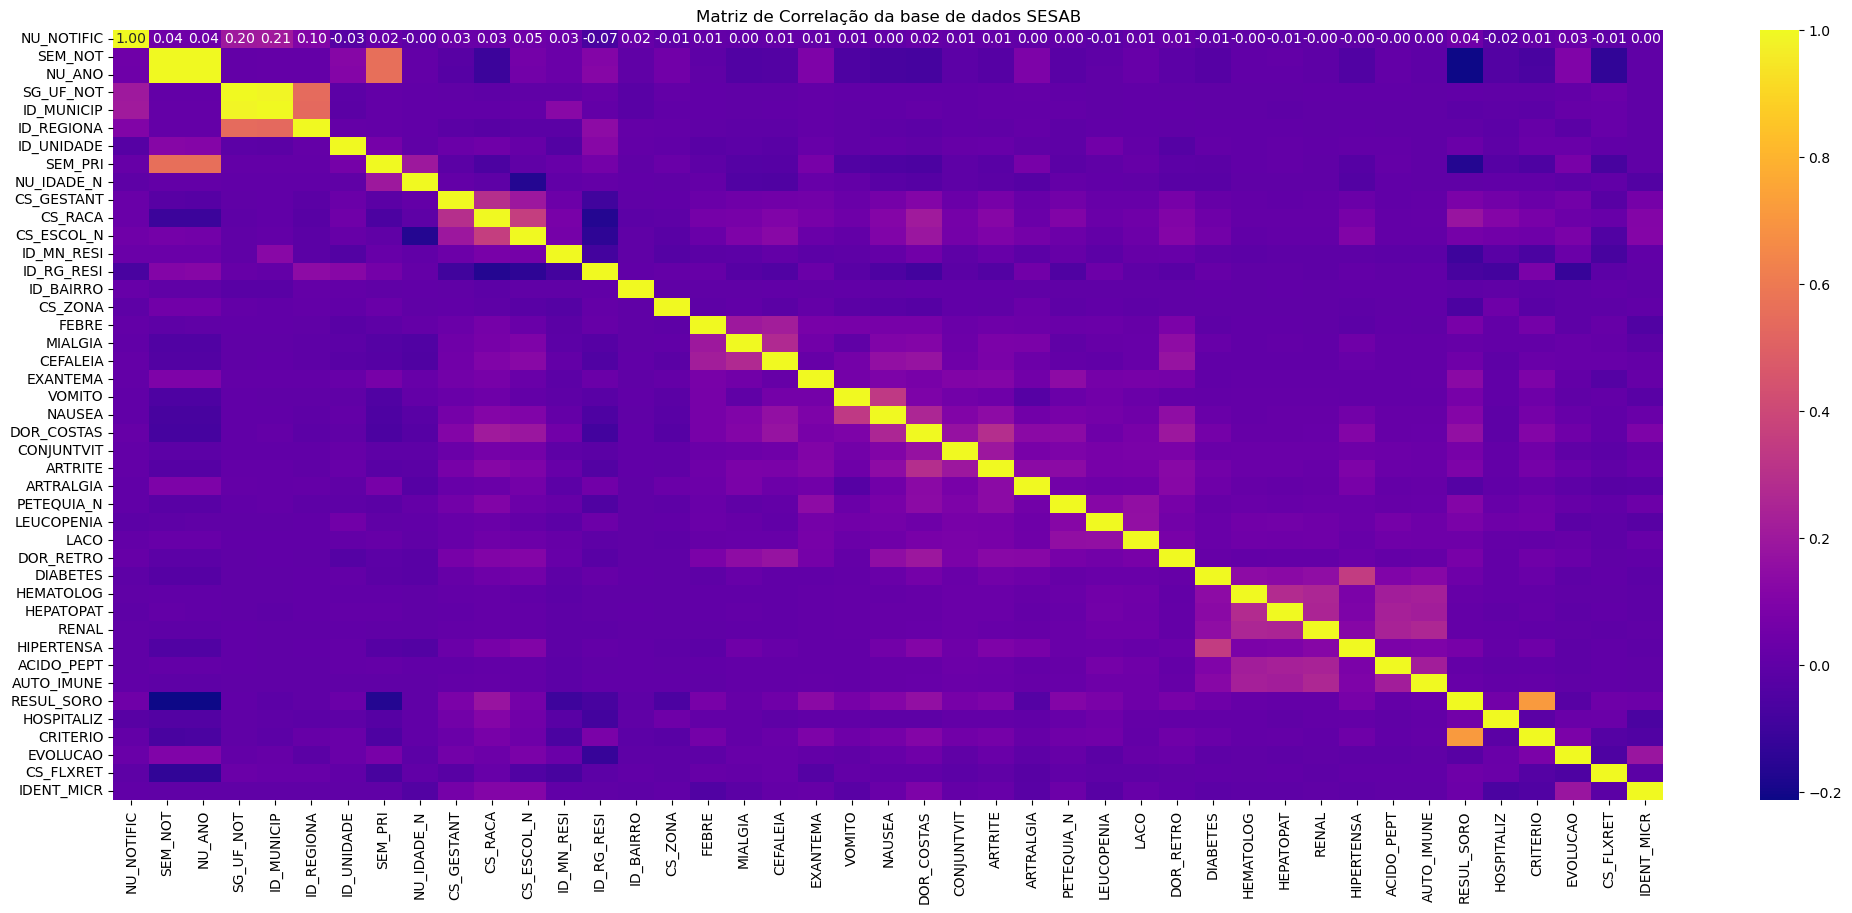

In [20]:
# Plotando matrizes
colunas_num = ['NU_NOTIFIC', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA',
               'ID_UNIDADE', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_MN_RESI',
               'ID_RG_RESI', 'ID_BAIRRO', 'CS_ZONA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA',
               'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 
               'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_SORO', 'HOSPITALIZ',
               'CRITERIO', 'EVOLUCAO', 'CS_FLXRET', 'IDENT_MICR']
df_analisenum = X_train[colunas_num]
matriz_correlacao = df_analisenum.corr()

plt.figure(figsize=(25, 10))
sns.heatmap(matriz_correlacao, annot=True, cmap='plasma', fmt=".2f")
plt.title('Matriz de Correlação da base de dados SESAB')
plt.show()

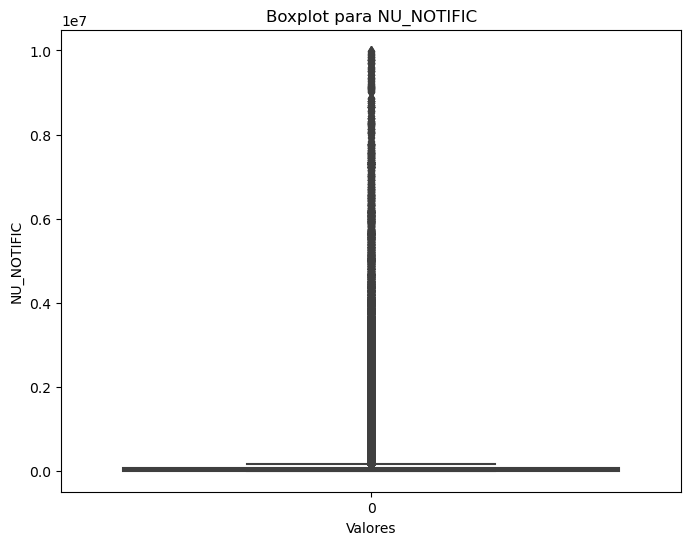

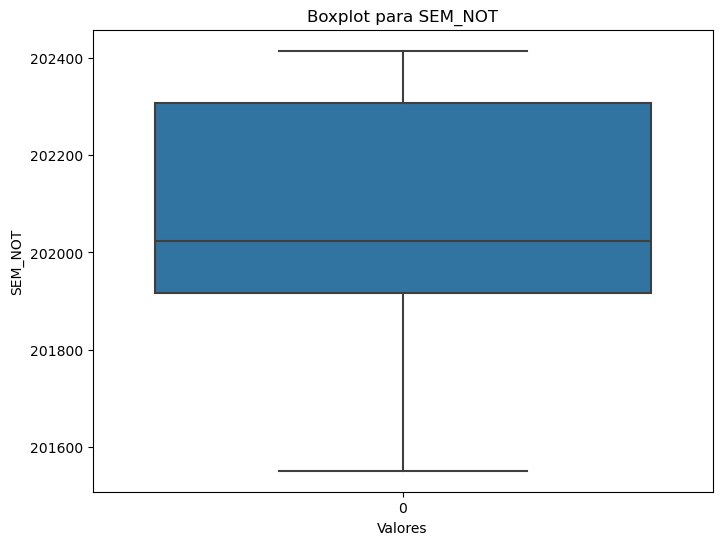

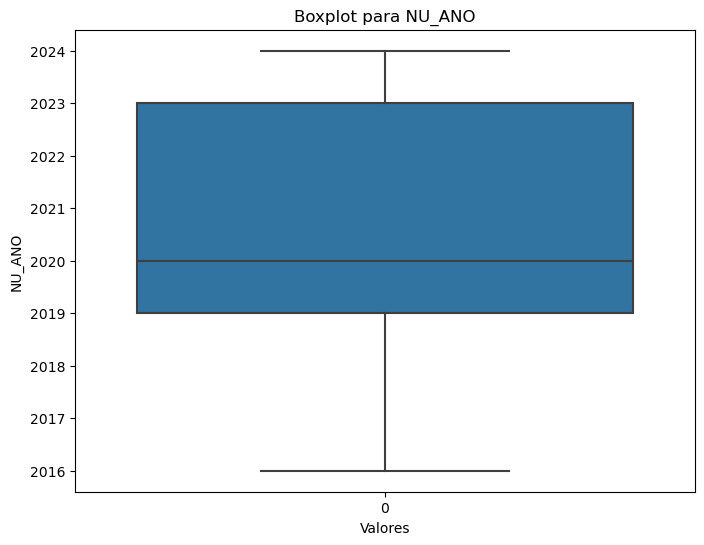

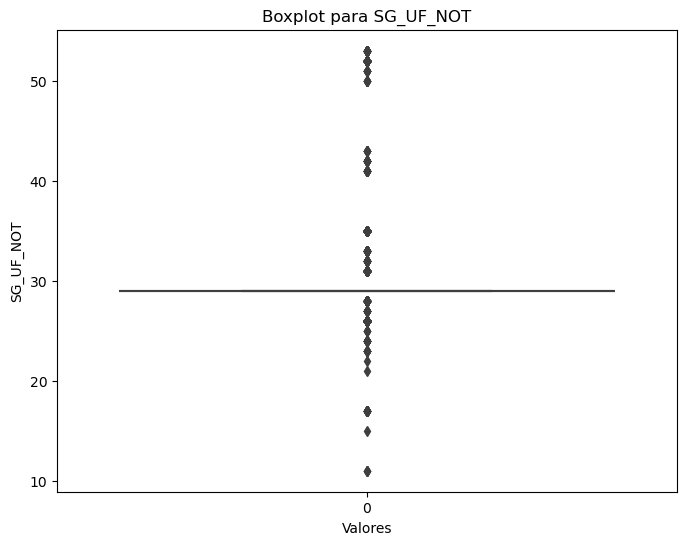

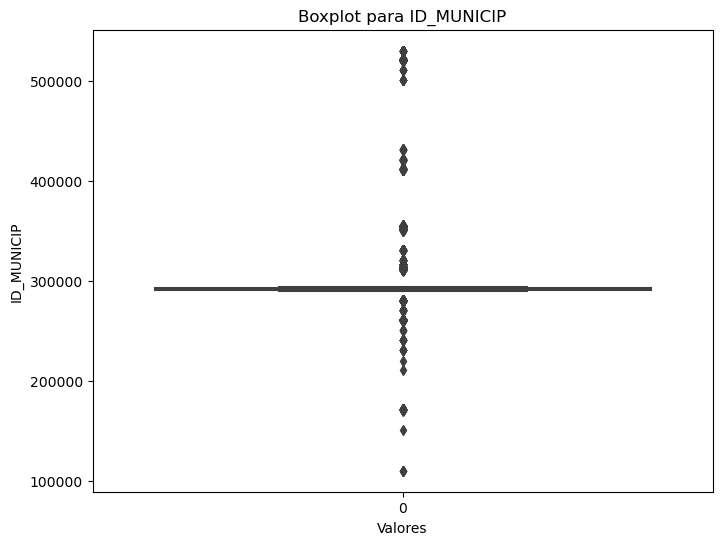

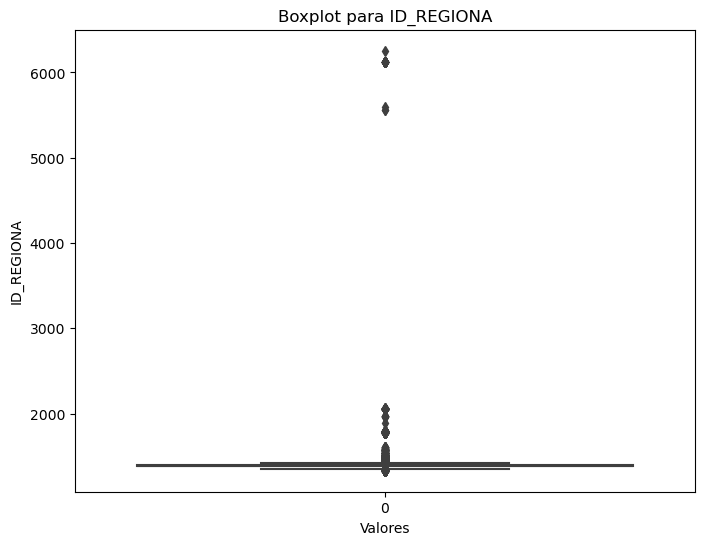

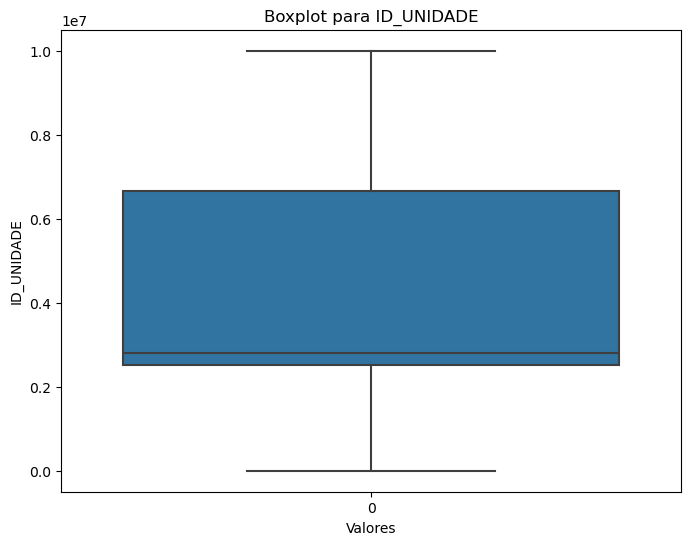

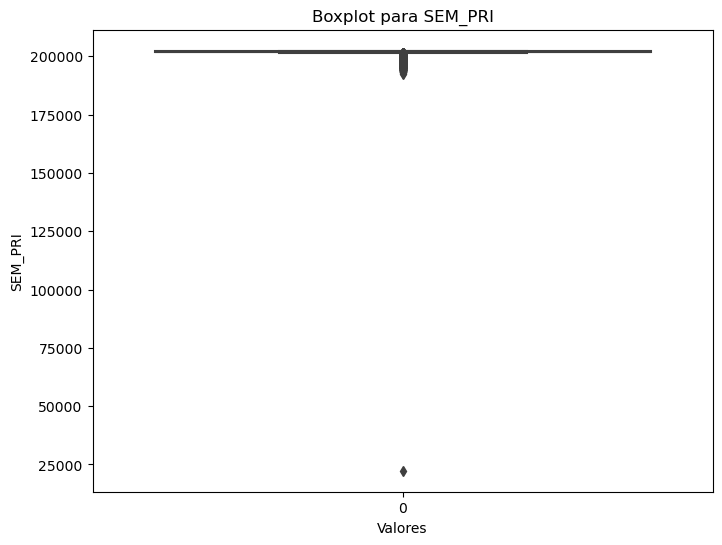

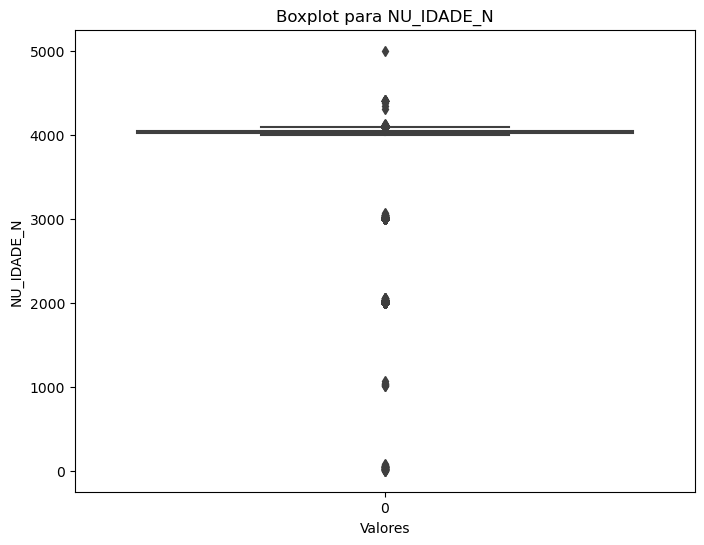

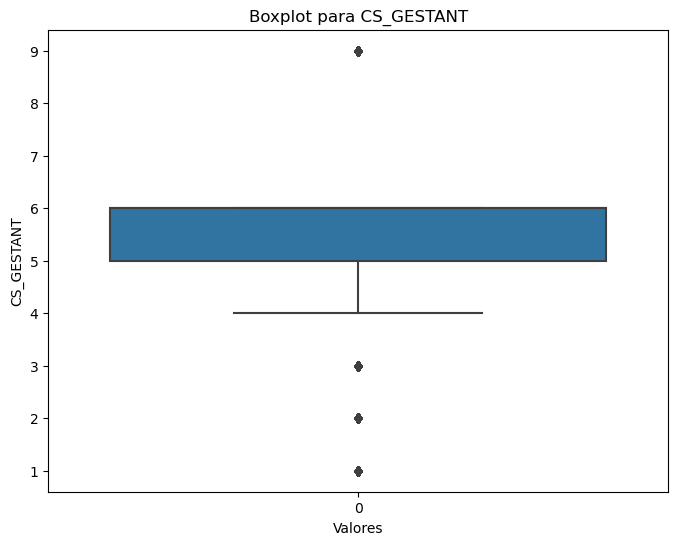

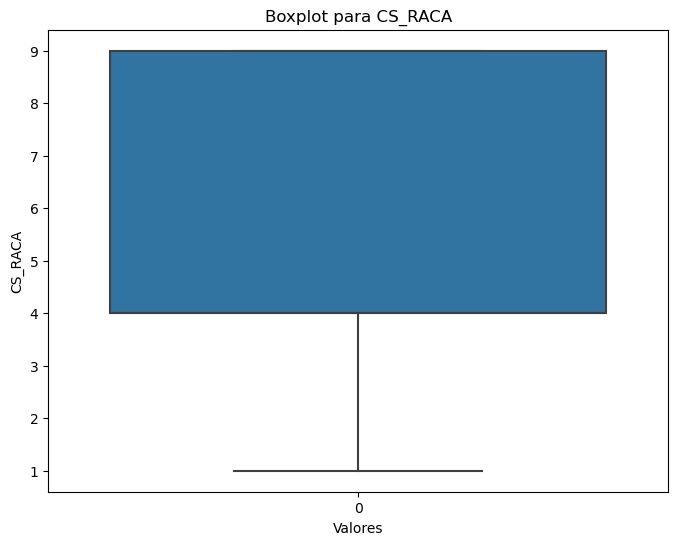

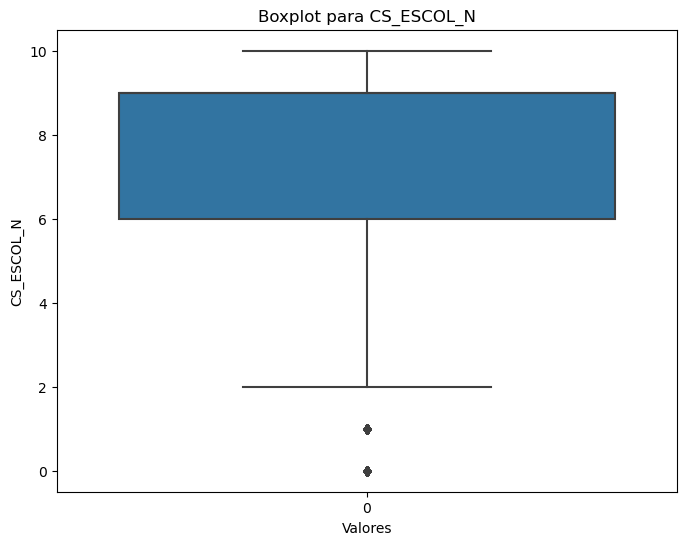

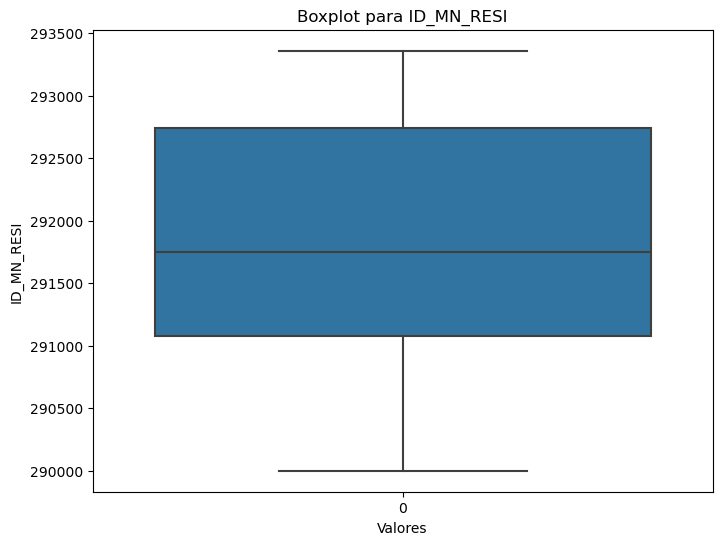

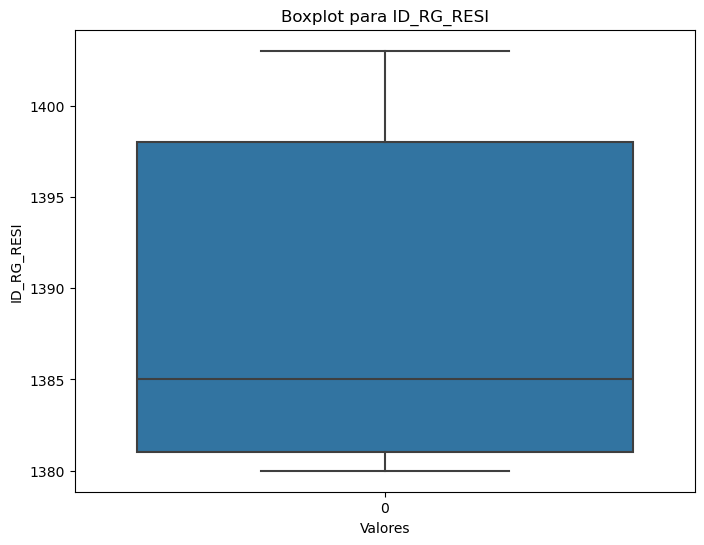

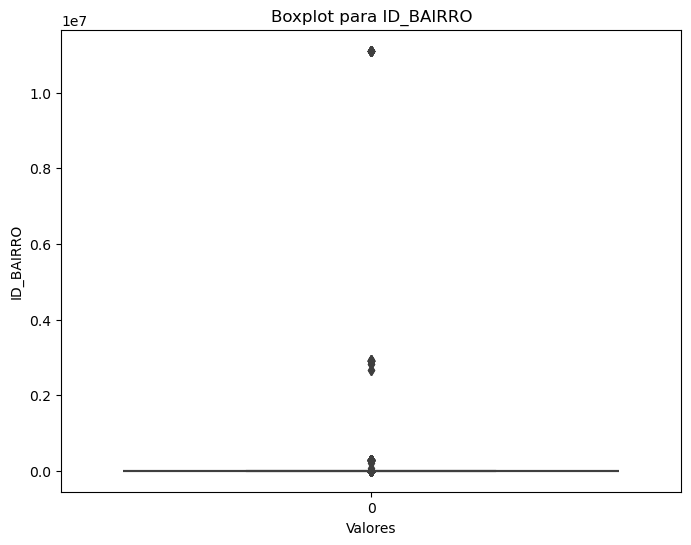

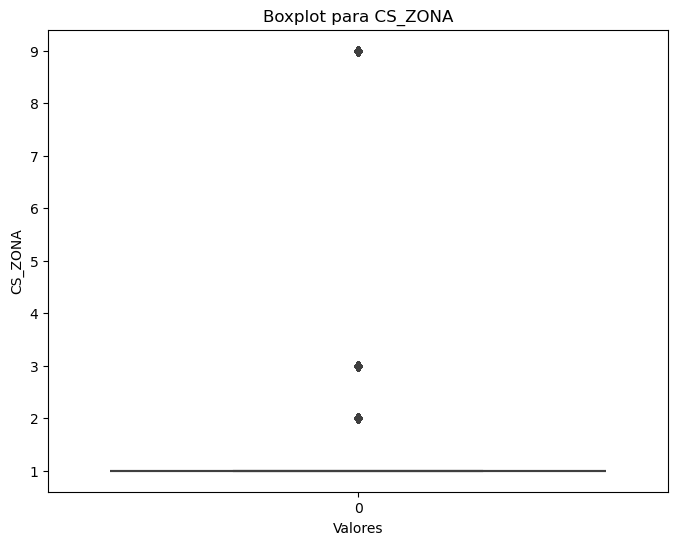

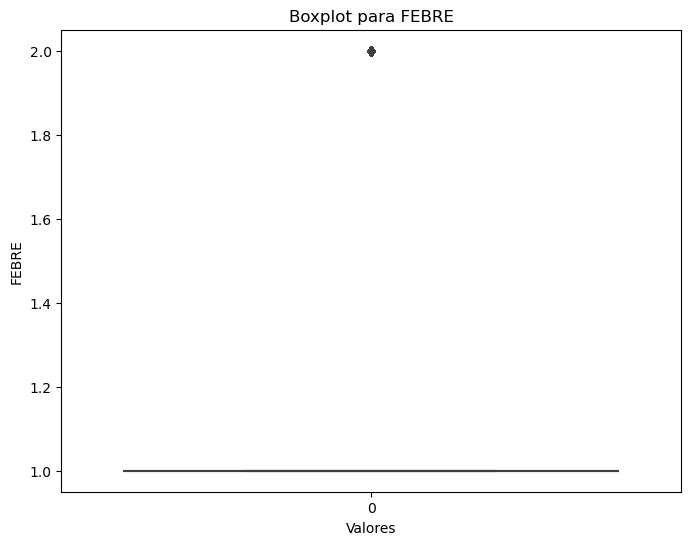

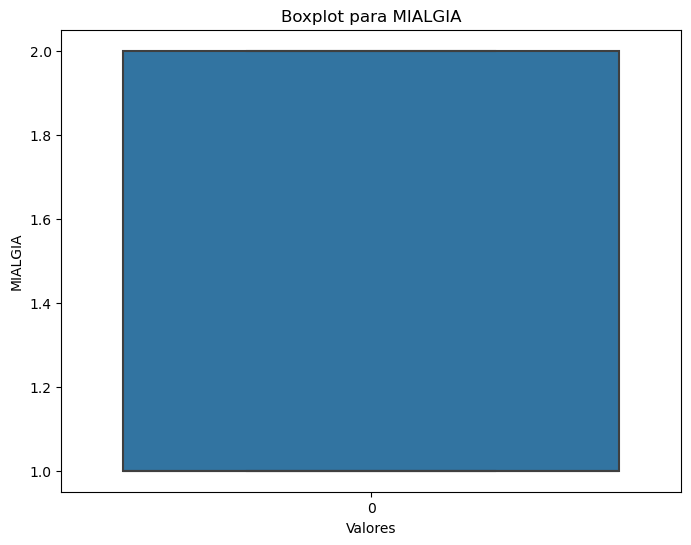

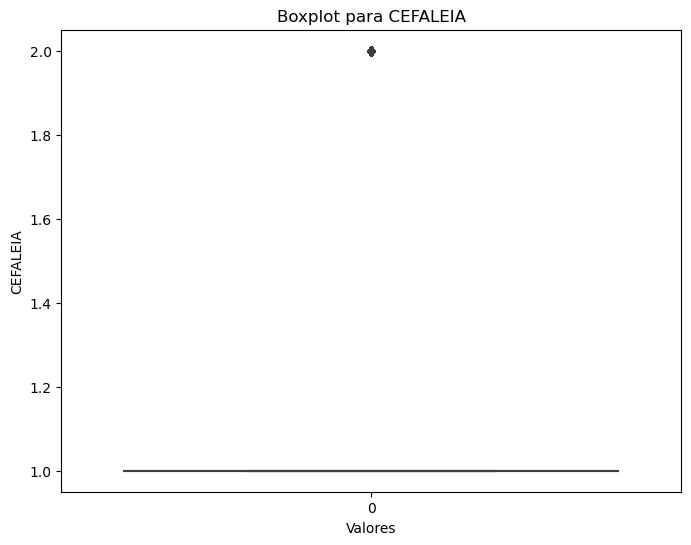

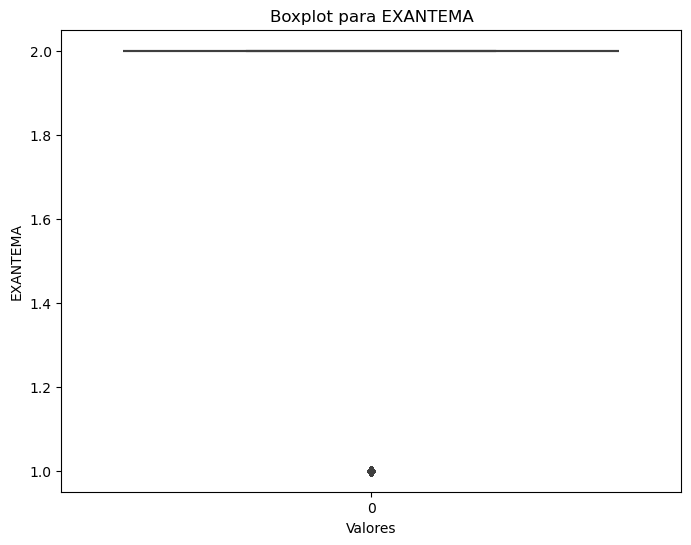

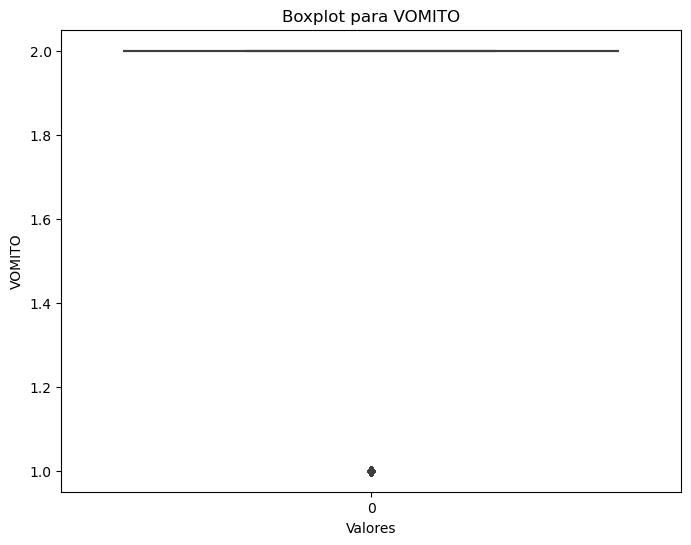

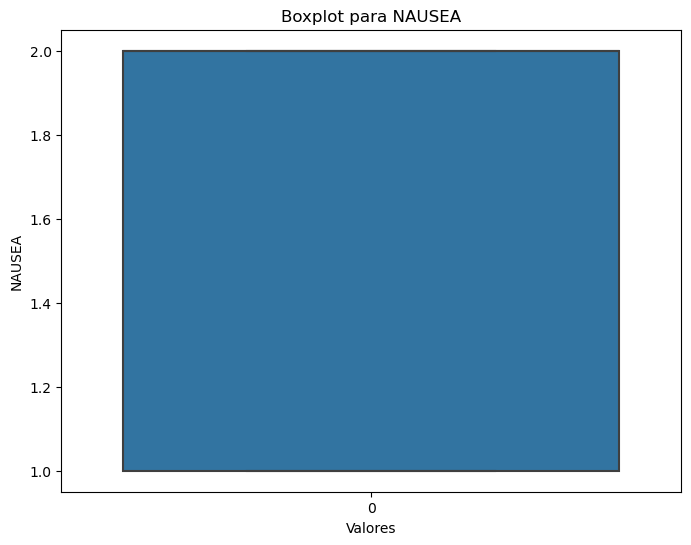

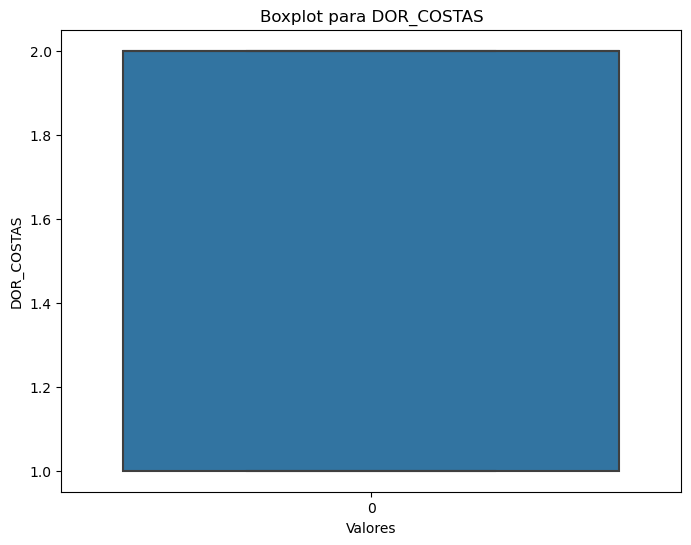

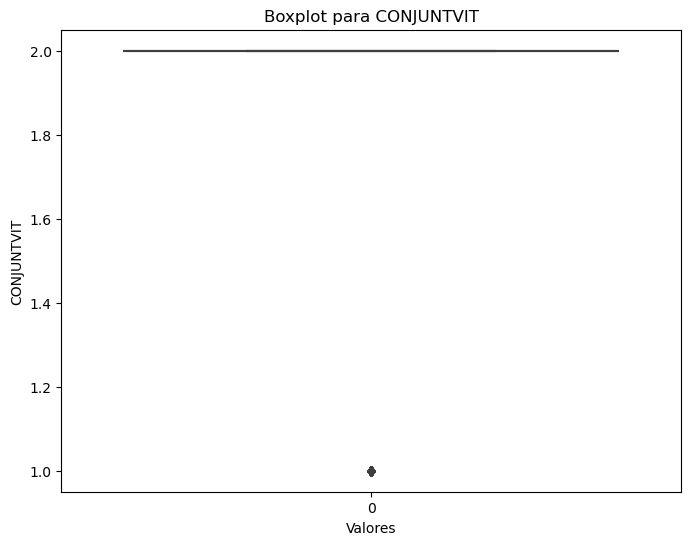

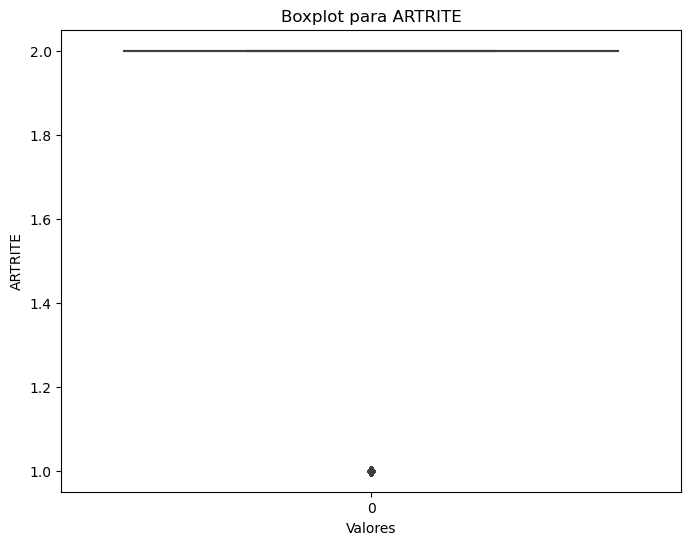

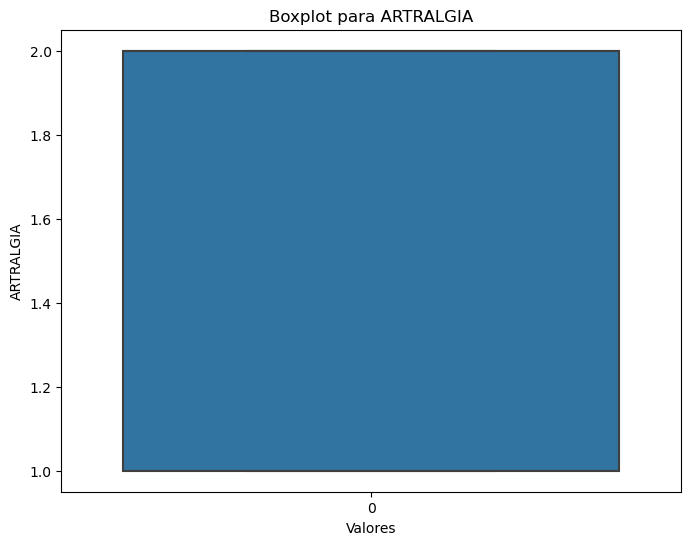

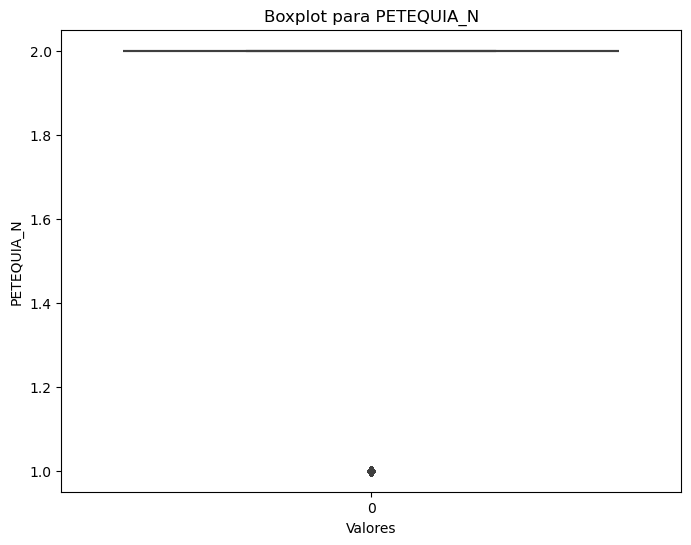

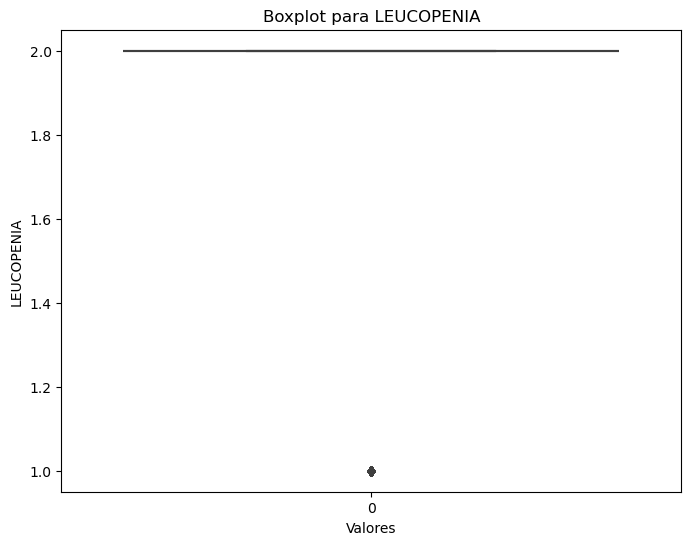

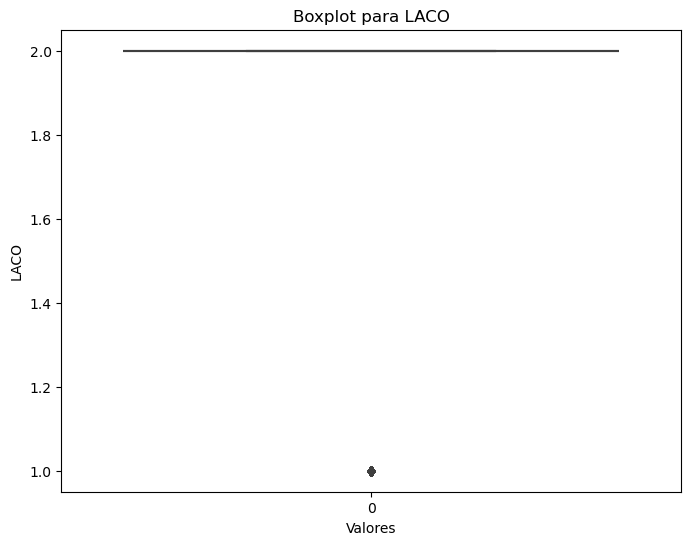

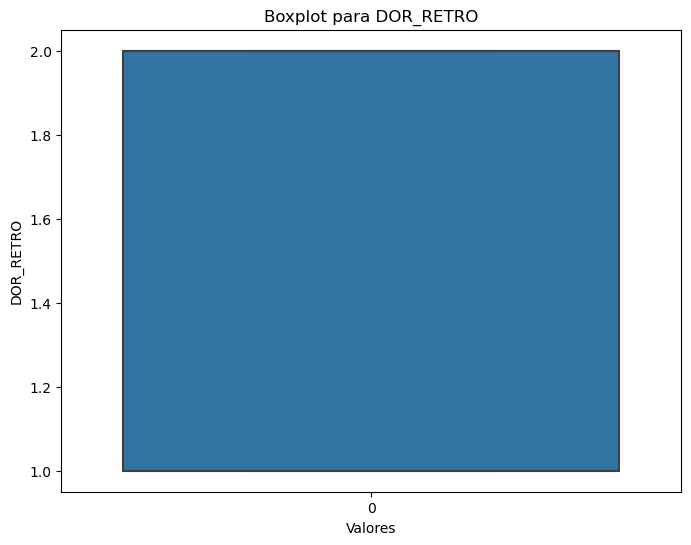

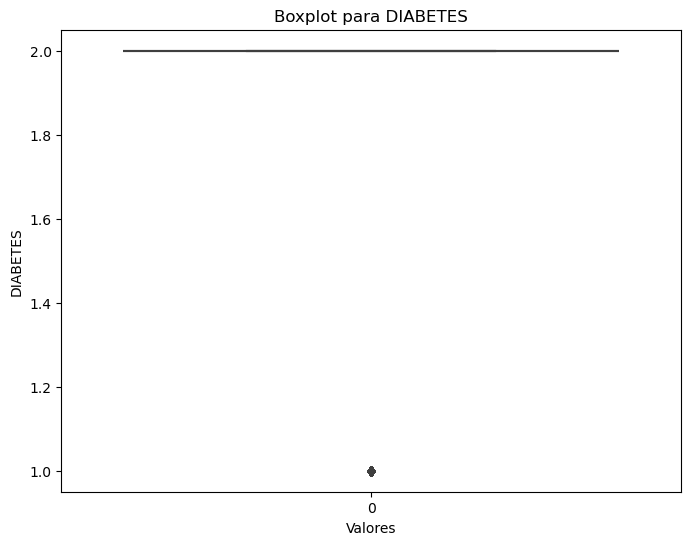

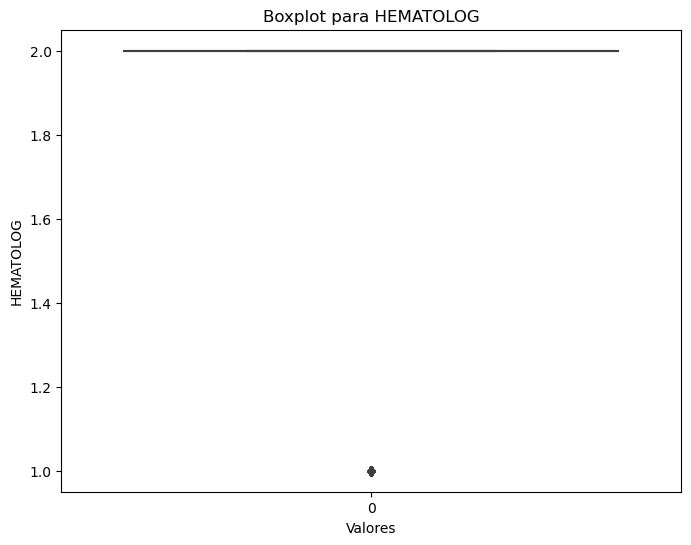

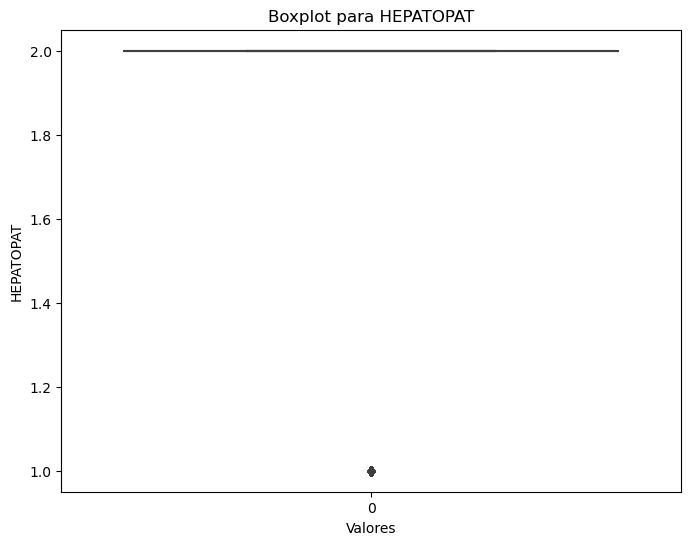

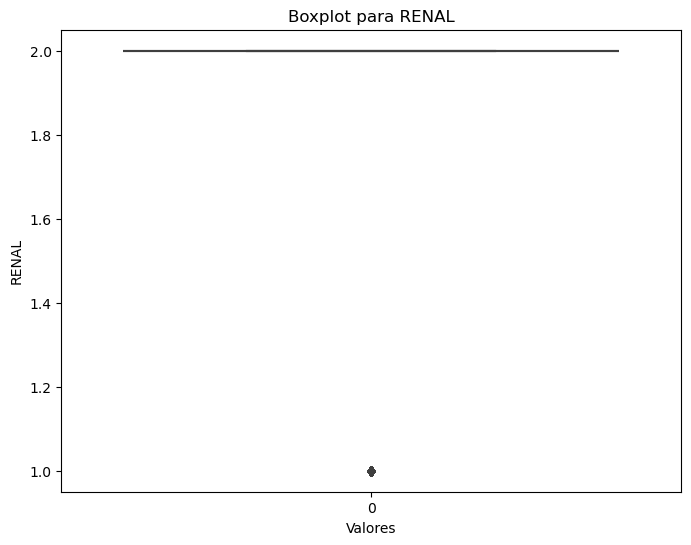

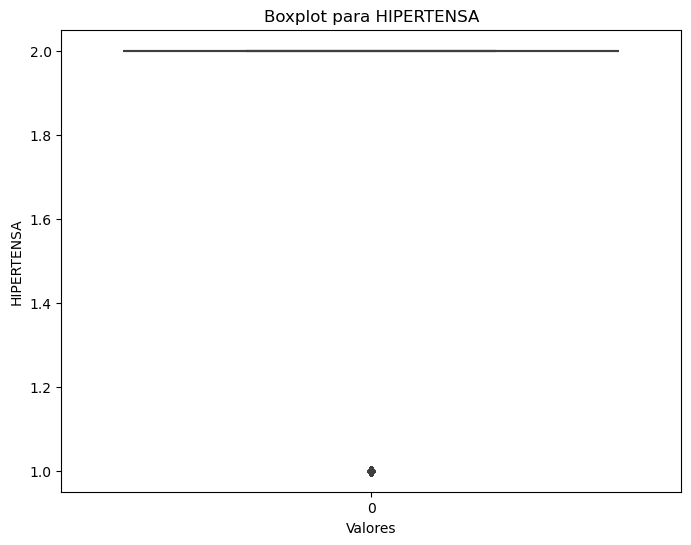

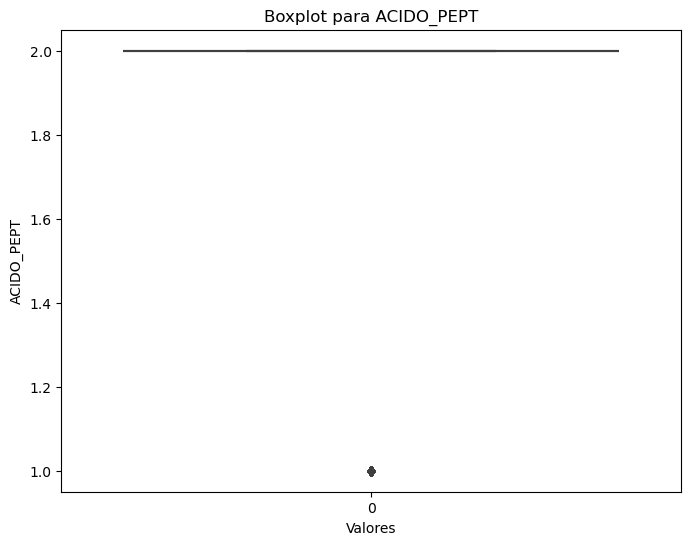

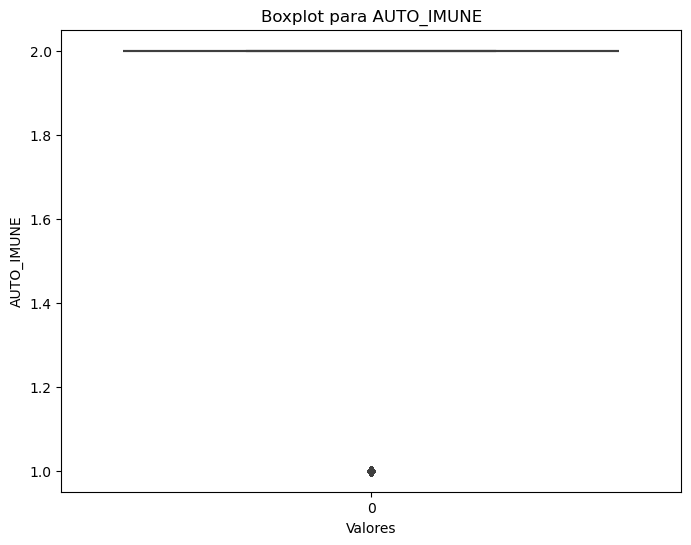

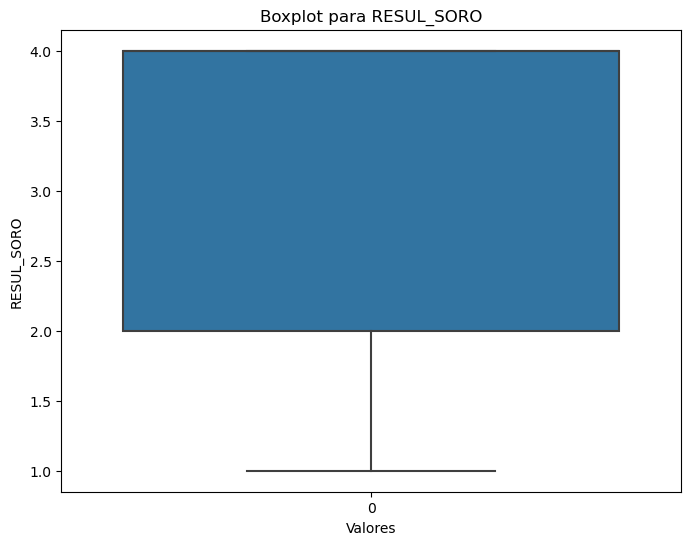

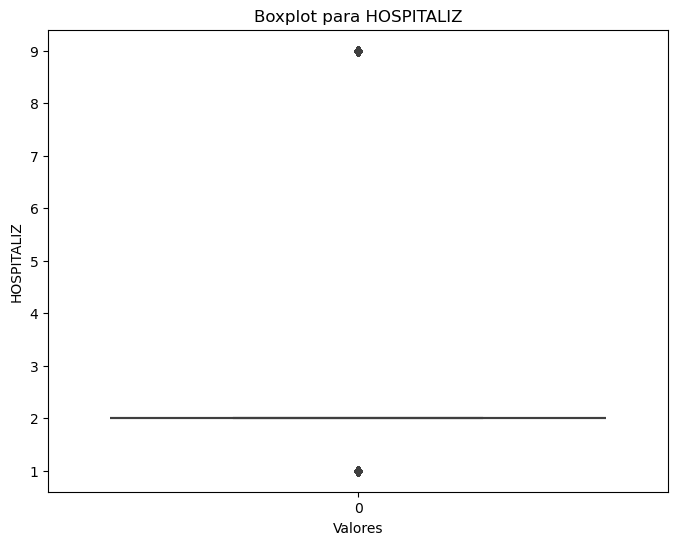

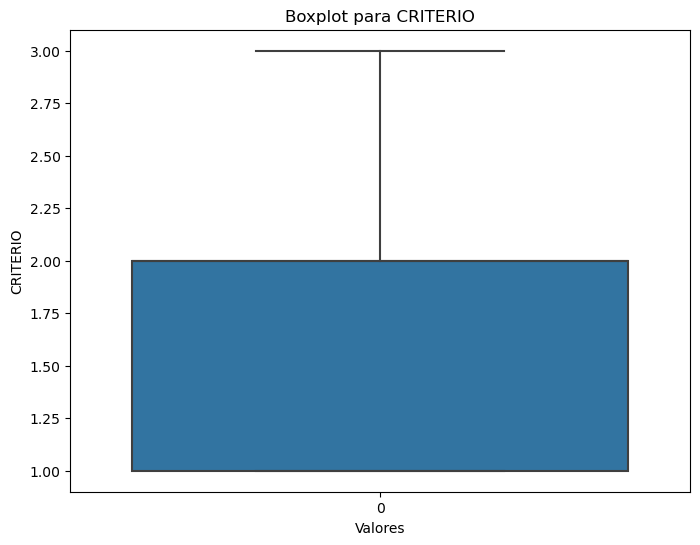

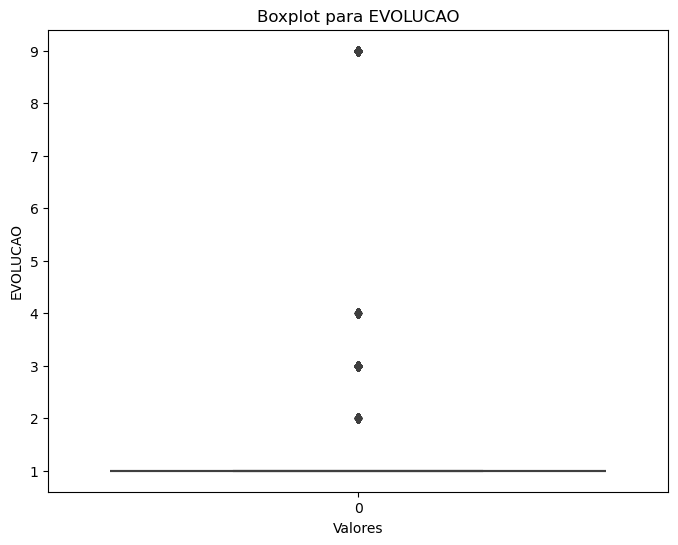

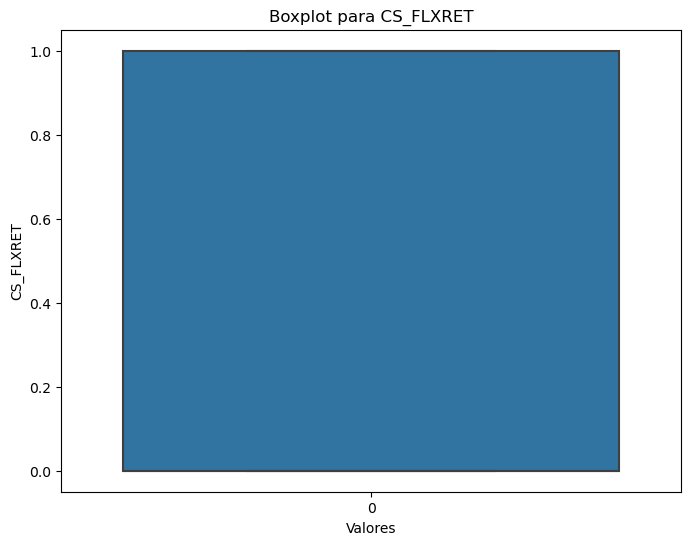

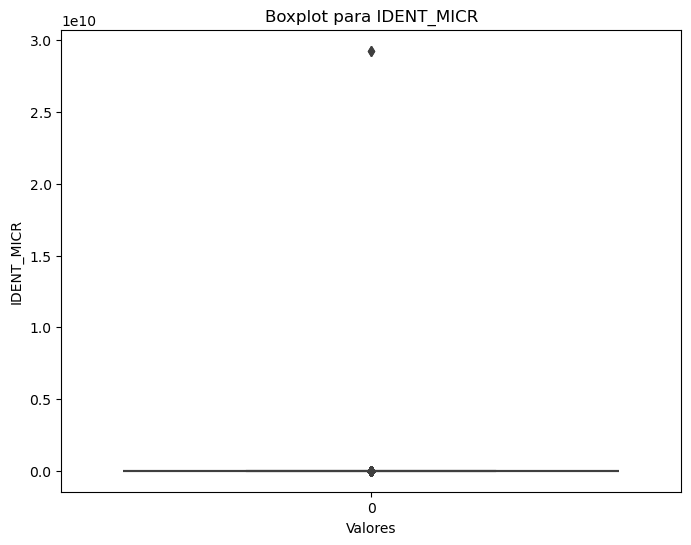

In [21]:
#Plotando boxplots
for coluna in df_analisenum:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=X_train[coluna])
    plt.title('Boxplot para {}'.format(coluna))
    plt.xlabel('Valores')
    plt.ylabel('{}'.format(coluna))
    plt.show()

## CODIFICAÇÃO/ENCODING

In [23]:
pd.set_option('display.max_rows', 50)
colunas_cat = ['DT_NOTIFIC', 'DT_SIN_PRI', 'CS_SEXO', 'NM_BAIRRO', 'DT_INVEST', 'DT_ENCERRA', 'DT_DIGITA', 'ID_CNS_SUS_HASHED']
for coluna in colunas_cat:
    print(X_train[coluna].value_counts())
    print()

DT_NOTIFIC
2024-02-27    1370
2024-02-28    1323
2024-02-26    1310
2024-03-05    1302
2024-03-11    1231
              ... 
2017-09-07       1
2017-11-25       1
2016-08-14       1
2017-10-28       1
2016-12-18       1
Name: count, Length: 3011, dtype: int64

DT_SIN_PRI
2024-02-26    1177
2024-02-25    1022
2024-03-04    1017
2024-03-01     986
2024-02-27     974
              ... 
2001-09-21       1
2010-09-25       1
1981-06-01       1
1978-09-20       1
1996-04-24       1
Name: count, Length: 4398, dtype: int64

CS_SEXO
F    186069
M    143039
I       737
Name: count, dtype: int64

NM_BAIRRO
CENTRO                  35618
ZONA RURAL              11501
SANTO ANTONIO            2891
SANTA CRUZ               1983
SANTA LUZIA              1459
                        ...  
PROJETO MANICOBA            1
AS CAROBAS                  1
ALTO O BONFIM               1
ALTO DO MIRNTE              1
ORLA NORTE VILAGE  I        1
Name: count, Length: 13716, dtype: int64

DT_INVEST
2024-02-26    1

### Podemos dropar 'ID_CNS_SUS_HASHED', pois não influencia no algoritmo, é apenas uma chave HASH.
### O dicionário informa que 'DT_ENCERRA' é a data de encerramento de caso. Podemos considerar excluí-la também, tendo em vista que a predição é se HÁ ou NÃO dengue, e essa coluna apenas informa o final do caso. Não temos informação sobre 'DT_DIGITA', 'DT_NOTIFIC', 'DT_SIN_PRI'
### A coluna 'CS_SEXO' pode ser codificada como ONE-HOT encoder, pois só tem 3 valores distintos.
### A coluna 'NM_BAIRRO' tem 19834 valores diferentes.

In [25]:
colunas_drop = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_INVEST', 'DT_ENCERRA', 'DT_DIGITA', 'ID_CNS_SUS_HASHED']
X_train.drop(colunas_drop, axis=1, inplace=True)
X_teste.drop(colunas_drop, axis=1, inplace=True)
X_cv.drop(colunas_drop, axis=1, inplace=True)

In [26]:
from sklearn.preprocessing import OneHotEncoder

col_to_encode = 'CS_SEXO'
encoder = OneHotEncoder(sparse_output=False, drop=None)  #drop='first' para evitar a dummy variable trap
encoded_data = encoder.fit_transform(X_train[[col_to_encode]])
new_columns = encoder.get_feature_names_out([col_to_encode])
X_train[new_columns] = encoded_data
X_train = X_train.drop([col_to_encode], axis=1)

In [27]:
from sklearn.preprocessing import OneHotEncoder

col_to_encode = 'CS_SEXO'
encoder = OneHotEncoder(sparse_output=False, drop=None)  #drop='first' para evitar a dummy variable trap
encoded_data = encoder.fit_transform(X_teste[[col_to_encode]])
new_columns = encoder.get_feature_names_out([col_to_encode])
X_teste[new_columns] = encoded_data
X_teste = X_teste.drop([col_to_encode], axis=1)

In [28]:
from sklearn.preprocessing import OneHotEncoder

col_to_encode = 'CS_SEXO'
encoder = OneHotEncoder(sparse_output=False, drop=None)  #drop='first' para evitar a dummy variable trap
encoded_data = encoder.fit_transform(X_cv[[col_to_encode]])
new_columns = encoder.get_feature_names_out([col_to_encode])
X_cv[new_columns] = encoded_data
X_cv = X_cv.drop([col_to_encode], axis=1)

In [29]:
# Conferindo se deu certo
X_train.iloc[:, -4:]
X_teste.iloc[:, -4:]
X_cv.iloc[:, -4:]

,CS_SEXO_F,CS_SEXO_I,CS_SEXO_M,CS_SEXO_nan
185838,1.0,0.0,0.0,0.0
409858,1.0,0.0,0.0,0.0
577177,1.0,0.0,0.0,0.0
446009,1.0,0.0,0.0,0.0
519048,1.0,0.0,0.0,0.0
...,...,...,...,...
205677,1.0,0.0,0.0,0.0
340611,1.0,0.0,0.0,0.0
139822,0.0,0.0,1.0,0.0
282590,0.0,0.0,1.0,0.0


## INPUTAÇÃO DE VALORES

In [31]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_train.shape[0]
valores_nulos_por_coluna = X_train.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
quantidade_acima_70 = (porcentagem_nulos_por_coluna > 70).sum()
print("----------------------------------------------")

NU_NOTIFIC      0.000000
CS_SEXO_I       0.000000
CS_SEXO_F       0.000000
CS_SEXO_M       0.000000
ID_MN_RESI      0.000000
NU_IDADE_N      0.000000
SEM_PRI         0.000000
CS_SEXO_nan     0.000000
ID_MUNICIP      0.000000
NU_ANO          0.000000
TP_NOT          0.000000
SG_UF_NOT       0.000000
SEM_NOT         0.000000
CS_FLXRET       0.000606
ID_RG_RESI      0.004547
CS_GESTANT      0.020614
ID_REGIONA      0.040924
ID_UNIDADE      0.085790
IDENT_MICR      0.809393
CS_RACA         1.520870
CS_ZONA         8.890890
NM_BAIRRO      11.626758
DOR_RETRO      12.870858
AUTO_IMUNE     12.870858
ACIDO_PEPT     12.870858
HIPERTENSA     12.870858
RENAL          12.870858
HEPATOPAT      12.870858
HEMATOLOG      12.870858
DIABETES       12.870858
LEUCOPENIA     12.870858
PETEQUIA_N     12.870858
FEBRE          12.870858
MIALGIA        12.870858
LACO           12.870858
CEFALEIA       12.870858
EXANTEMA       12.870858
CONJUNTVIT     12.870858
NAUSEA         12.870858
DOR_COSTAS     12.870858


### Antes de inputar as colunas, vamos dar uma olhada nas últimas com maior quantidade de valores ausentes.
### Comecemos pelas últimas, de 23% para cima.

In [33]:
# Não for informado oq seria essa coluna no dicionário e pelos valores, também não conseguimos desvendar
X_train['CS_ESCOL_N'].value_counts()

CS_ESCOL_N
9.0     121308
10.0     32909
6.0      30876
3.0      16647
5.0      12828
1.0      12293
4.0       8169
8.0       7038
2.0       6373
7.0       3102
0.0       2410
Name: count, dtype: int64

In [34]:
# Temos 2 colunas 'NM_BAIRRO' e 'ID_BAIRRO' que não batem os valores
X_train['ID_BAIRRO'].value_counts()

ID_BAIRRO
6.0           3544
1.0           2946
2.0           2797
7.0           2595
10.0          2533
8.0           2482
14.0          2282
17.0          2269
3.0           2261
19.0          2175
5.0           1723
4.0           1684
105.0         1581
107.0         1574
18.0          1564
20.0          1495
192.0         1481
32.0          1430
85.0          1330
23.0          1292
148.0         1280
685.0         1251
115.0         1239
106.0         1200
79.0          1180
31.0          1178
244.0         1155
123.0         1140
84.0          1138
12.0          1133
15.0          1106
183.0         1070
74.0          1053
147.0         1052
116.0         1022
179.0         1019
67.0          1011
441.0         1009
9.0            996
24.0           976
100.0          973
58.0           943
252.0          940
650.0          931
88.0           931
104.0          923
75.0           917
16.0           915
610.0          914
13.0           907
80.0           906
145.0          899
60

In [35]:
# Podemos dropar a coluna 'EVOLUCAO' pois estamos tentando predizer 'Este indivíduo foi diagnosticado com dengue com base nos dados disponíveis?'
# Pode ser uma variável futura muito importante para prever a evolução do caso, de leve para grave.

# Da mesma forma 'HOSPITALIZ'.

# Vamos dropar a coluna 'NM_BAIRRO', pois é uma coluna categórica (nos poupa o trabalho do encoder, além de ter que analisar casos em que há digitação errada.)
colunas_drop2 = ['CS_ESCOL_N', 'NM_BAIRRO', 'EVOLUCAO', 'HOSPITALIZ', 'NU_NOTIFIC']
X_train.drop(colunas_drop2, axis=1, inplace=True)
X_teste.drop(colunas_drop2, axis=1, inplace=True)
X_cv.drop(colunas_drop2, axis=1, inplace=True)

In [36]:
# 'RESUL_SORO' é importante, pois é associado ao que queremos saber, se há dengue ou não.
# Porém, tem uma quantidade muito grande de valores ausentes. Como temos um dataset muito grande, podemos pegar a quantidade que temos para simular um dataset.
X_train = X_train.dropna(subset=['RESUL_SORO'])
X_teste = X_teste.dropna(subset=['RESUL_SORO'])
X_cv = X_cv.dropna(subset=['RESUL_SORO'])

In [37]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_train.shape[0]
valores_nulos_por_coluna = X_train.isnull().sum()
porcentagem_nulos_por_coluna2 = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna2.sort_values())
print("----------------------------------------------")
colunas_nulas_2 = porcentagem_nulos_por_coluna2.index.tolist()

TP_NOT          0.000000
CS_SEXO_I       0.000000
CS_SEXO_F       0.000000
CS_FLXRET       0.000000
RESUL_SORO      0.000000
CS_SEXO_M       0.000000
ID_MN_RESI      0.000000
NU_IDADE_N      0.000000
CS_SEXO_nan     0.000000
SEM_PRI         0.000000
ID_MUNICIP      0.000000
SG_UF_NOT       0.000000
SEM_NOT         0.000000
NU_ANO          0.000000
ID_RG_RESI      0.007084
CS_GESTANT      0.021253
ID_REGIONA      0.034714
ID_UNIDADE      0.149482
IDENT_MICR      0.916729
CS_RACA         1.198691
DOR_RETRO       3.229806
ACIDO_PEPT      3.229806
HIPERTENSA      3.229806
RENAL           3.229806
HEPATOPAT       3.229806
HEMATOLOG       3.229806
DIABETES        3.229806
AUTO_IMUNE      3.229806
LACO            3.229806
PETEQUIA_N      3.229806
FEBRE           3.229806
MIALGIA         3.229806
LEUCOPENIA      3.229806
CEFALEIA        3.229806
EXANTEMA        3.229806
CONJUNTVIT      3.229806
NAUSEA          3.229806
DOR_COSTAS      3.229806
ARTRITE         3.229806
ARTRALGIA       3.229806


In [38]:
print(colunas_nulas_2)

['TP_NOT', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA', 'ID_MN_RESI', 'ID_RG_RESI', 'ID_BAIRRO', 'CS_ZONA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_SORO', 'RESUL_NS1', 'RESUL_PCR_', 'CRITERIO', 'CS_FLXRET', 'IDENT_MICR', 'CS_SEXO_F', 'CS_SEXO_I', 'CS_SEXO_M', 'CS_SEXO_nan']


In [39]:
X_train.shape

(141154, 46)

In [40]:
# # Utilizando grid search para procurar melhores parâmetros para o inputador
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, r2_score

# param = {
#     'max_iter': [5, 10, 20],
#     'tol': [0.001, 0.01, 0.1]
# }

# grid_search = GridSearchCV(imputer, param, cv=5, scoring=make_scorer(r2_score))

# grid_search.fit(df)
# print(grid_search.best_params_)

In [41]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer()
X_train[colunas_nulas_2] = imputer.fit_transform(X_train[colunas_nulas_2])

In [42]:
X_teste[colunas_nulas_2] = imputer.transform(X_teste[colunas_nulas_2])

In [43]:
X_cv[colunas_nulas_2] = imputer.transform(X_cv[colunas_nulas_2])

In [44]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_train.shape[0]
valores_nulos_por_coluna = X_train.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
print("----------------------------------------------")

TP_NOT         0.0
PETEQUIA_N     0.0
LEUCOPENIA     0.0
LACO           0.0
DOR_RETRO      0.0
DIABETES       0.0
HEMATOLOG      0.0
HEPATOPAT      0.0
RENAL          0.0
HIPERTENSA     0.0
ACIDO_PEPT     0.0
AUTO_IMUNE     0.0
RESUL_SORO     0.0
RESUL_NS1      0.0
RESUL_PCR_     0.0
CRITERIO       0.0
CS_FLXRET      0.0
IDENT_MICR     0.0
CS_SEXO_F      0.0
CS_SEXO_I      0.0
ARTRALGIA      0.0
ARTRITE        0.0
CONJUNTVIT     0.0
DOR_COSTAS     0.0
SEM_NOT        0.0
NU_ANO         0.0
SG_UF_NOT      0.0
ID_MUNICIP     0.0
ID_REGIONA     0.0
ID_UNIDADE     0.0
SEM_PRI        0.0
NU_IDADE_N     0.0
CS_GESTANT     0.0
CS_SEXO_M      0.0
CS_RACA        0.0
ID_RG_RESI     0.0
ID_BAIRRO      0.0
CS_ZONA        0.0
FEBRE          0.0
MIALGIA        0.0
CEFALEIA       0.0
EXANTEMA       0.0
VOMITO         0.0
NAUSEA         0.0
ID_MN_RESI     0.0
CS_SEXO_nan    0.0
dtype: float64
----------------------------------------------


## NORMALIZAÇÃO/PADRONIZAÇÃO

In [46]:
# Instanciando padronizador
from sklearn.preprocessing import StandardScaler

# X_train_copy = X_train.copy()
scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)

In [47]:
X_teste[X_teste.columns] = scaler.transform(X_teste)

In [48]:
X_cv[X_cv.columns] = scaler.transform(X_cv)

In [49]:
# MOstrando dataframe
pd.set_option('display.max_rows', 10)
display(X_train)

,TP_NOT,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,SEM_PRI,NU_IDADE_N,CS_GESTANT,...,RESUL_SORO,RESUL_NS1,RESUL_PCR_,CRITERIO,CS_FLXRET,IDENT_MICR,CS_SEXO_F,CS_SEXO_I,CS_SEXO_M,CS_SEXO_nan
59526,0.0,-1.624782,-1.583623,-0.031709,-0.025246,-0.096334,-0.681314,-1.242005,0.035600,-0.018718,...,0.904526,0.479599,0.241729,0.942529,0.915523,-0.283899,0.864278,-0.038508,-0.861467,-0.010647
147352,0.0,-0.467135,-0.481504,-0.031709,-0.138225,-0.165023,-0.713541,-0.331852,0.083641,2.440868,...,-1.481389,0.156902,-0.081340,-0.962794,-1.092272,-0.283899,0.864278,-0.038508,-0.861467,-0.010647
357936,0.0,0.690513,0.620615,-0.031709,-0.136786,-0.165023,-0.713364,0.575421,0.092376,-0.018718,...,-0.686084,-0.274294,-0.499578,-0.962794,0.915523,-0.283899,0.864278,-0.038508,-0.861467,-0.010647
357018,0.0,0.576946,0.620615,-0.031709,-0.136786,-0.165023,-0.462900,0.483253,0.210295,-0.018718,...,-0.686084,-0.363178,-0.427856,-0.962794,-1.092272,-0.283899,-1.157035,-0.038508,1.160810,-0.010647
564364,0.0,1.320625,1.355361,-0.031709,0.158974,-0.044817,0.312162,1.073701,0.000661,-0.018718,...,0.904526,0.479599,0.241729,0.942529,-1.092272,-0.283899,-1.157035,-0.038508,1.160810,-0.010647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437121,0.0,0.979925,0.987988,-0.031709,-0.016611,0.058217,-0.681114,0.802959,0.192825,-0.838580,...,-0.686084,-0.490780,-0.246264,-0.962794,-1.092272,-0.283899,0.864278,-0.038508,-0.861467,-0.010647
535266,0.0,1.320625,1.355361,-0.031709,0.158974,-0.044817,0.312162,1.073701,0.026865,-0.018718,...,0.904526,0.479599,0.241729,0.942529,0.915523,-0.283899,0.864278,-0.038508,-0.861467,-0.010647
428794,0.0,1.031213,0.987988,-0.031709,0.120835,-0.182195,-0.113467,0.843282,0.136049,2.440868,...,0.904526,-1.252579,-0.838587,-0.962794,0.915523,-0.283899,0.864278,-0.038508,-0.861467,-0.010647
4298,0.0,-1.617456,-1.583623,-0.031709,0.102125,-0.182195,1.347447,-1.239125,0.057437,-0.018718,...,-0.686084,-0.359706,0.241729,-0.404980,0.915523,3.520648,-1.157035,-0.038508,1.160810,-0.010647


In [50]:
# Vendo dataframe finalizado após pré-processamento
X_train.shape

(141154, 46)

In [51]:
X_cv.shape

(46987, 46)

In [52]:
X_teste.shape

(47123, 46)

In [53]:
y_train.value_counts()

CLASSI_FIN
0    200790
1    129087
Name: count, dtype: int64

In [54]:
y_cv.value_counts()

CLASSI_FIN
0    67021
1    42939
Name: count, dtype: int64

In [55]:
y_teste.value_counts()

CLASSI_FIN
0    66953
1    43007
Name: count, dtype: int64

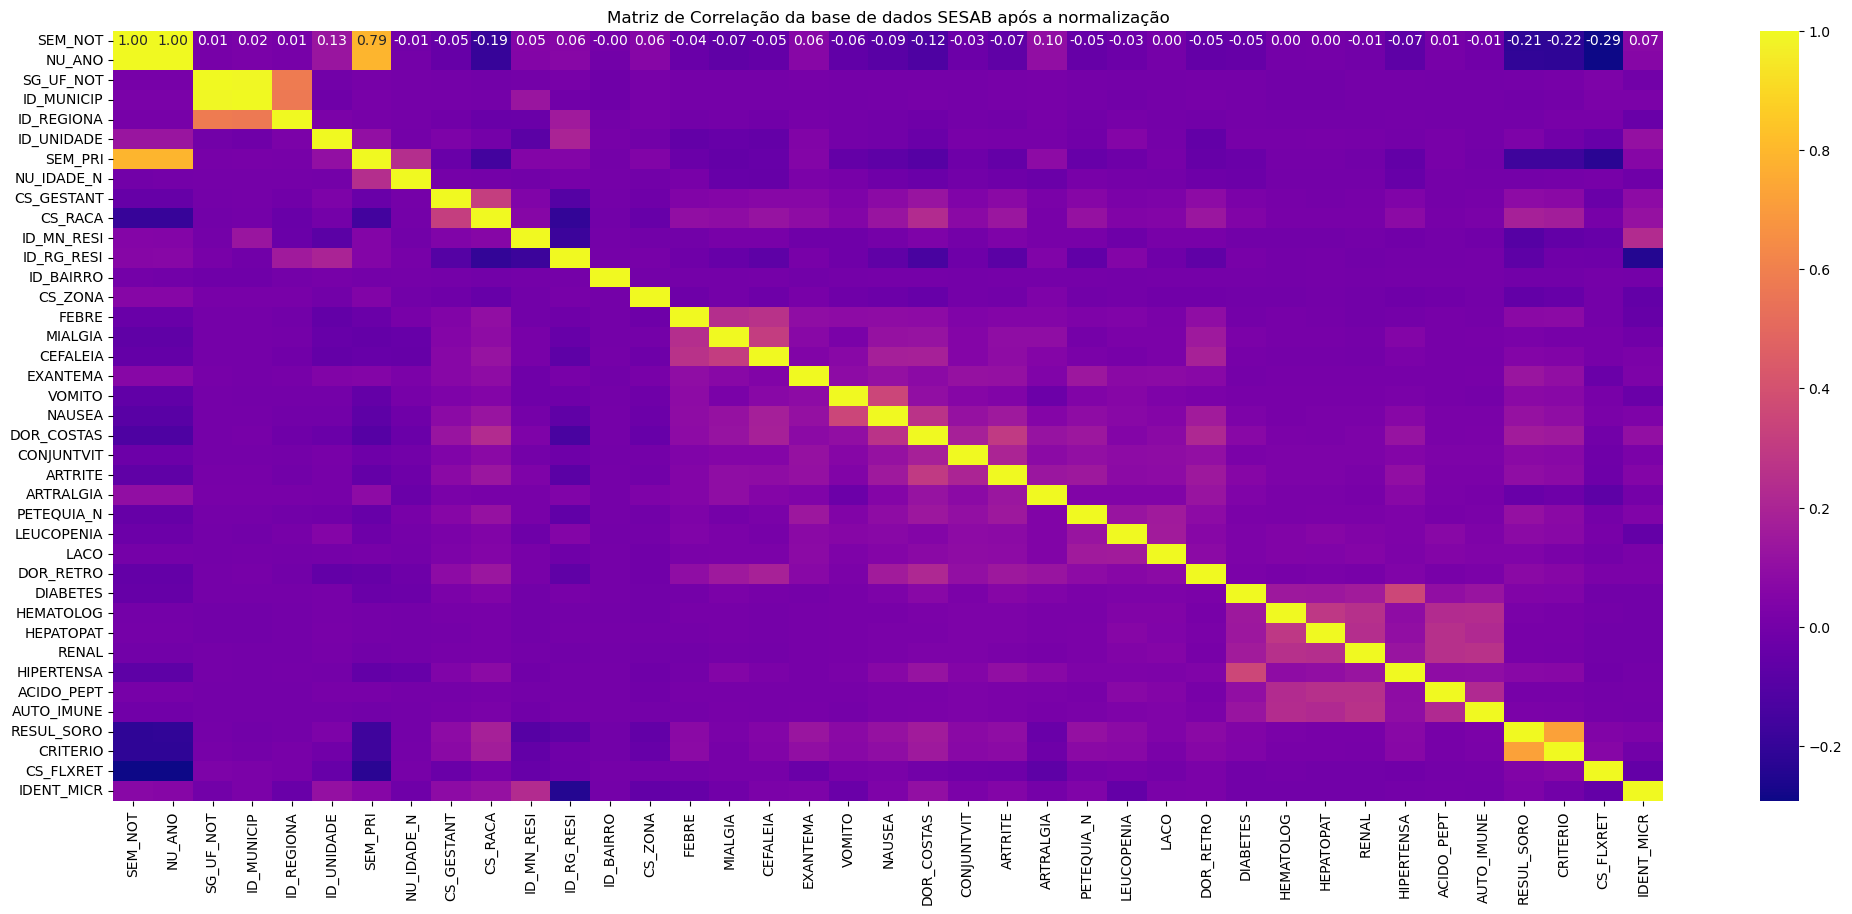

In [56]:
# Plotando matrizes após normalização
colunas_numn = ['SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA',
               'ID_UNIDADE', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA', 'ID_MN_RESI',
               'ID_RG_RESI', 'ID_BAIRRO', 'CS_ZONA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA',
               'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 
               'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_SORO',
               'CRITERIO', 'CS_FLXRET', 'IDENT_MICR']
df_analisenumn = X_train[colunas_numn]
matriz_correlacaon = df_analisenumn.corr()

plt.figure(figsize=(25, 10))
sns.heatmap(matriz_correlacaon, annot=True, cmap='plasma', fmt=".2f")
plt.title('Matriz de Correlação da base de dados SESAB após a normalização')
plt.show()

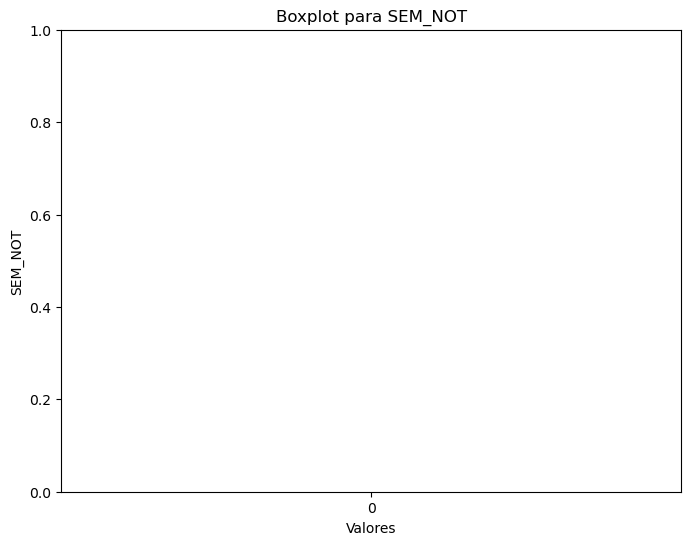

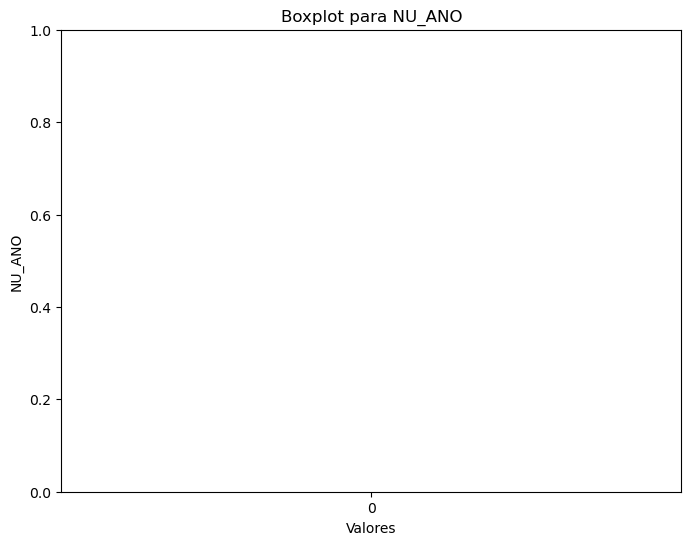

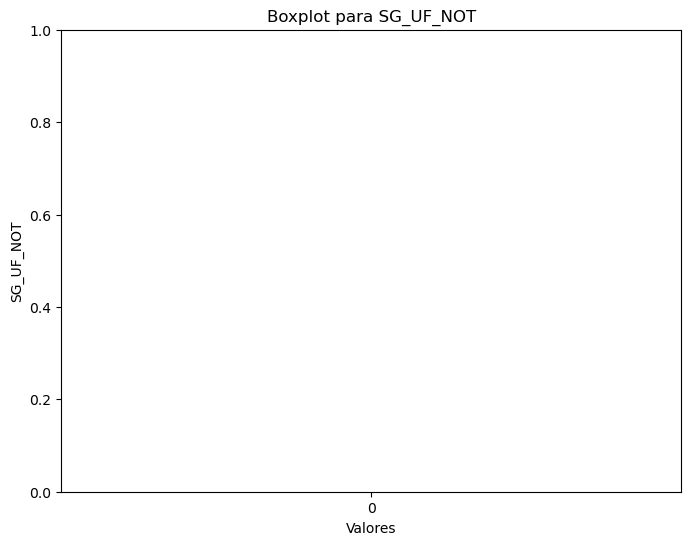

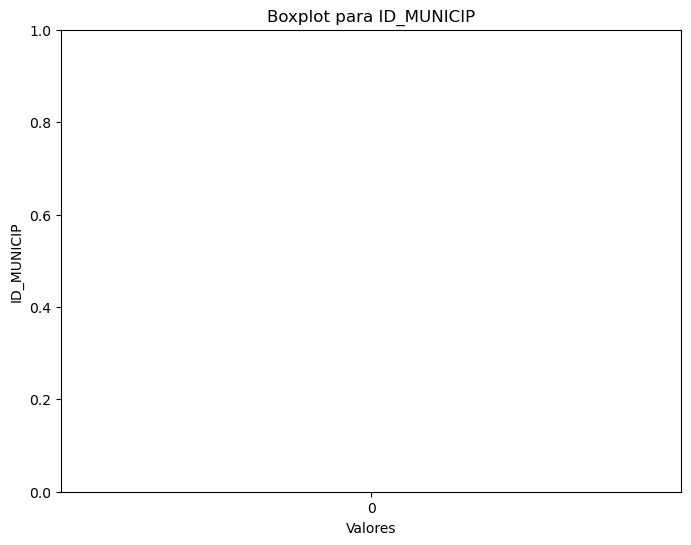

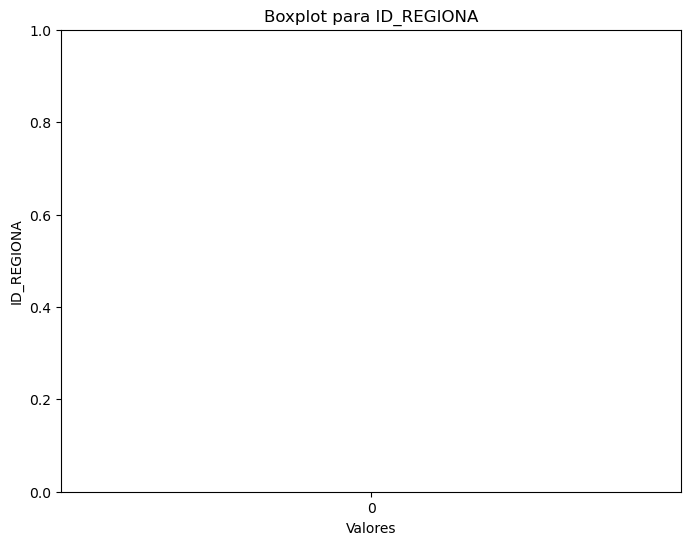

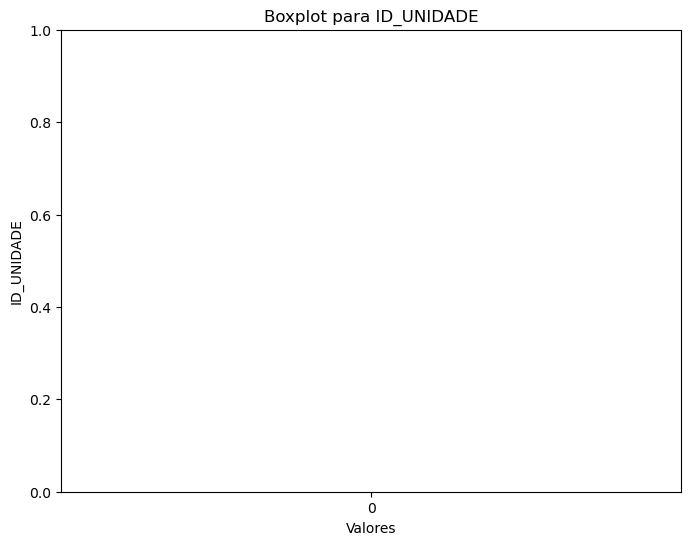

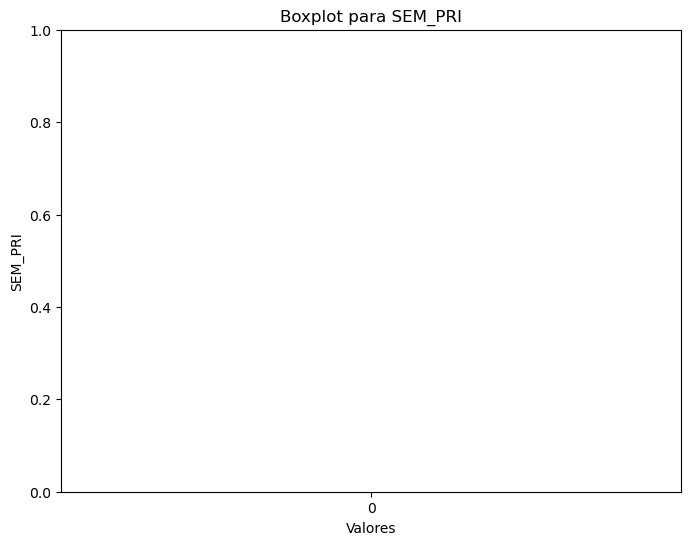

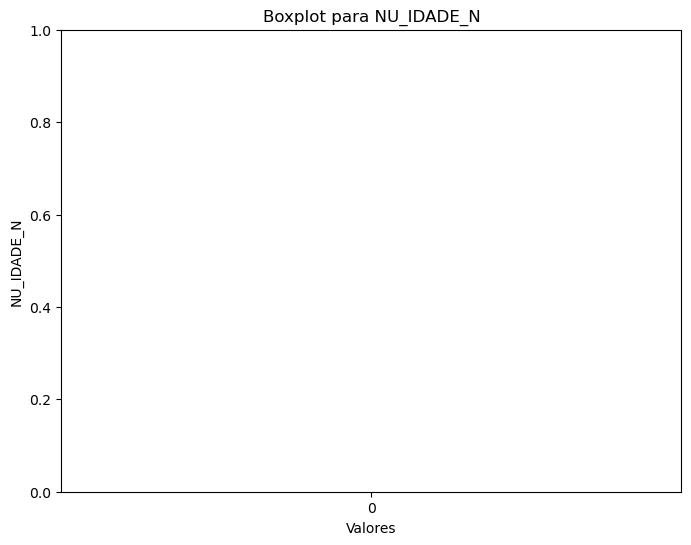

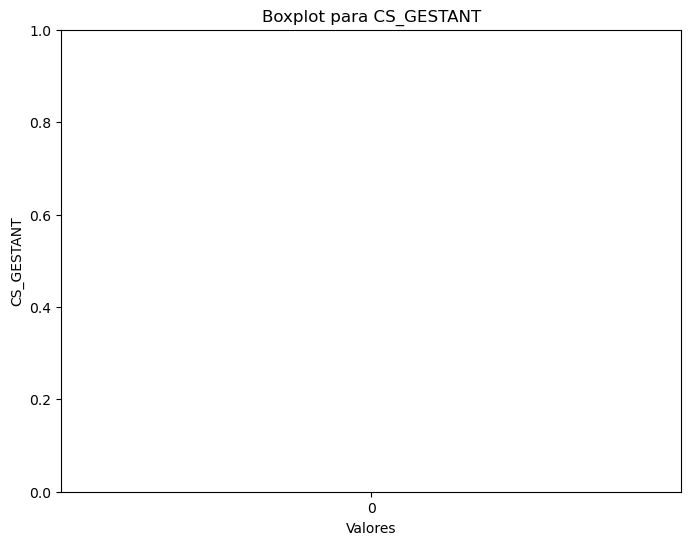

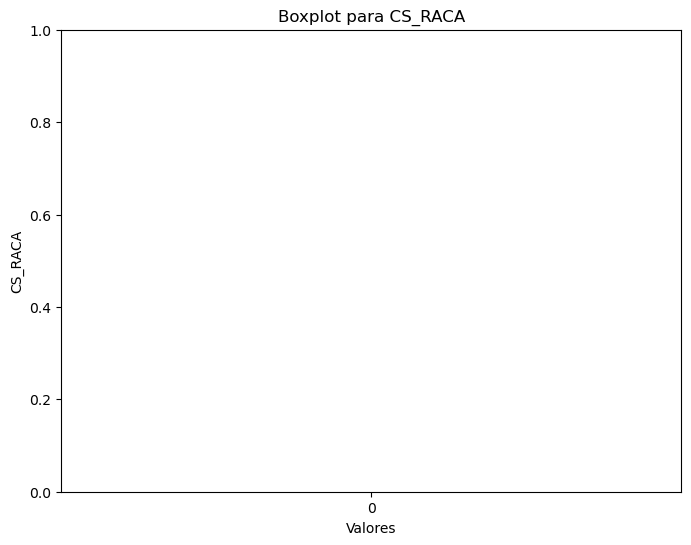

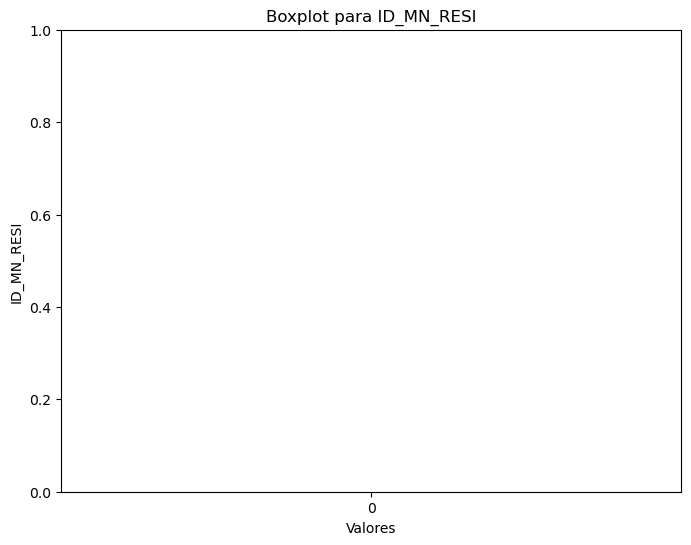

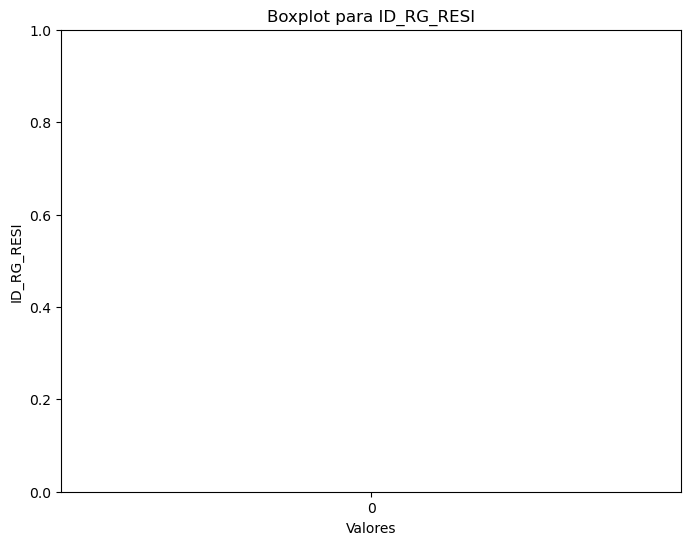

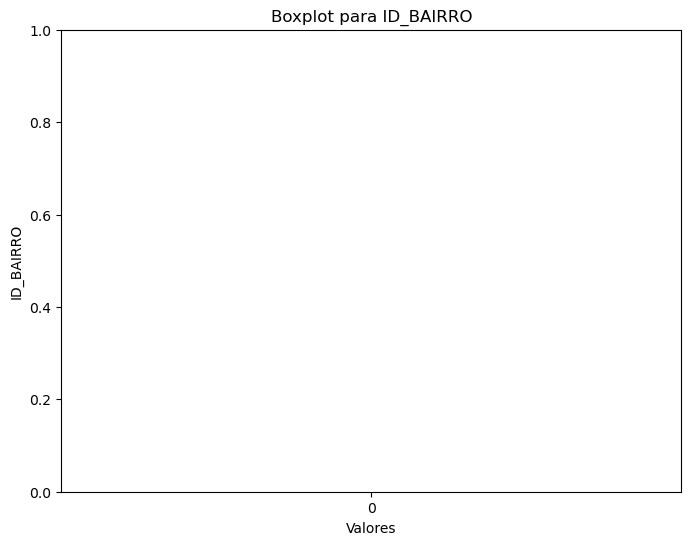

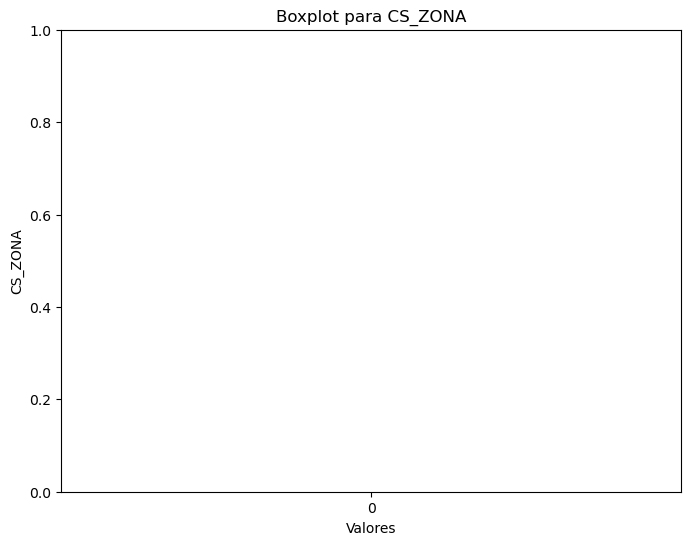

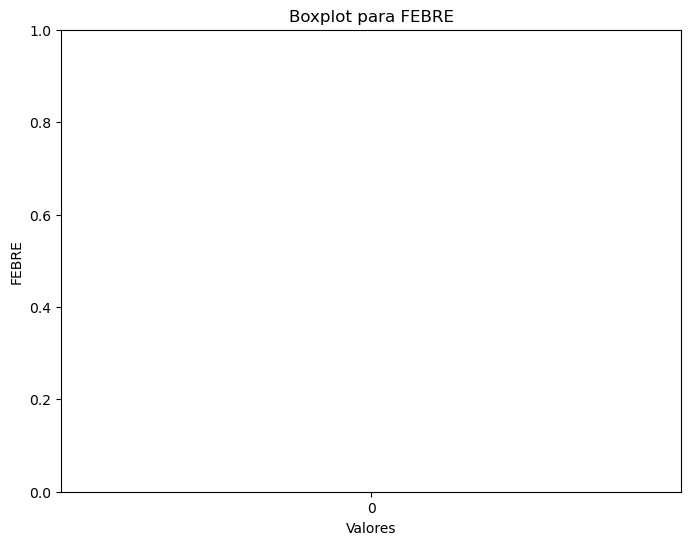

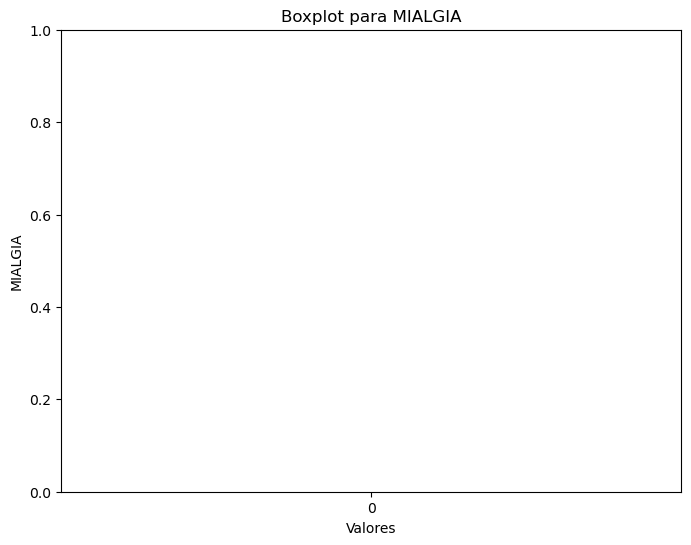

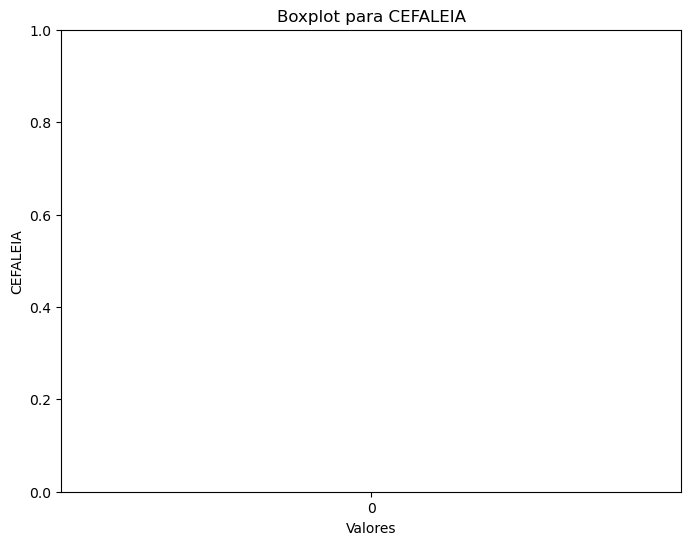

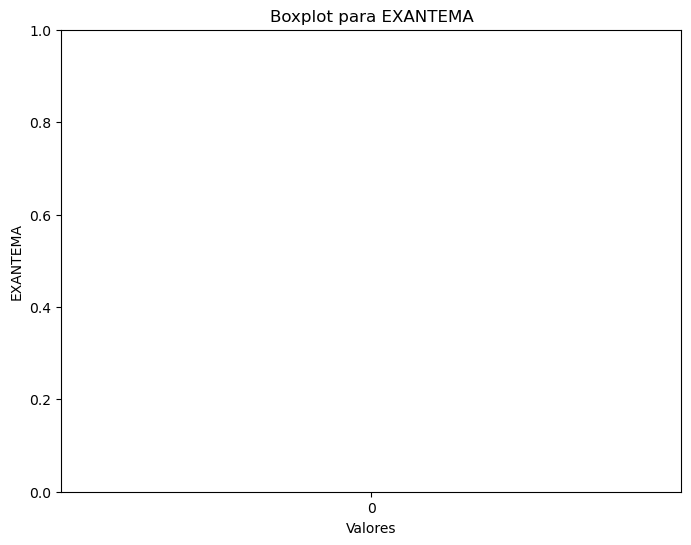

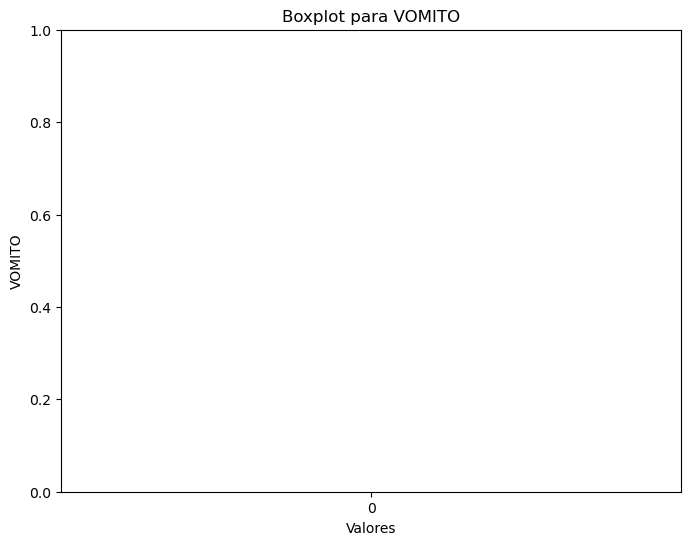

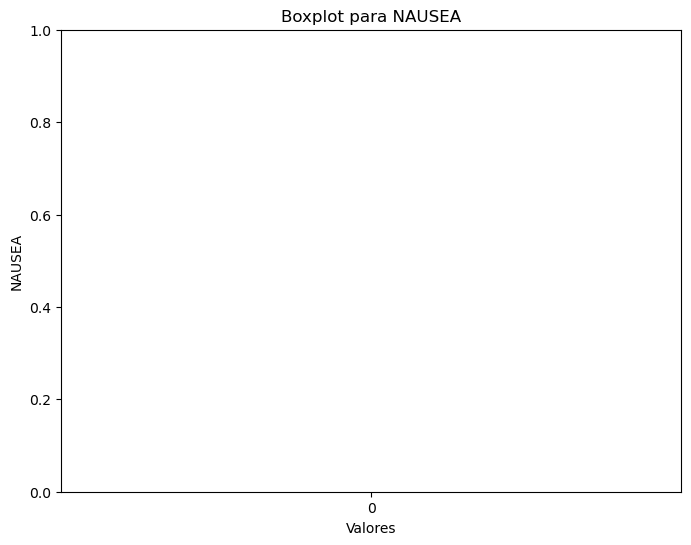

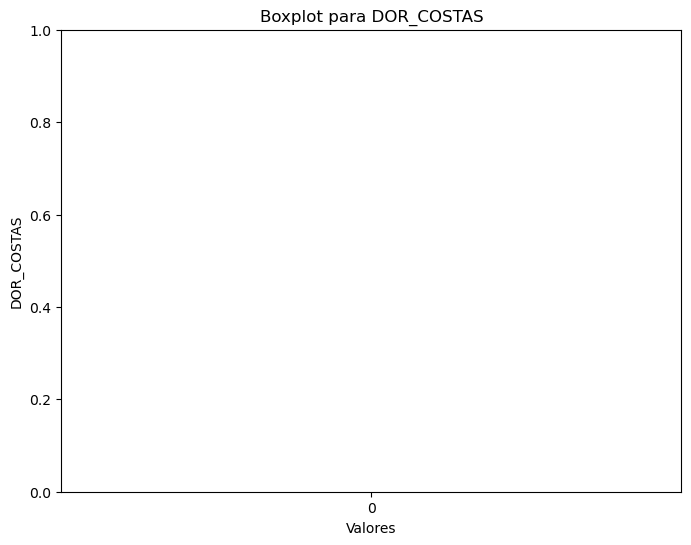

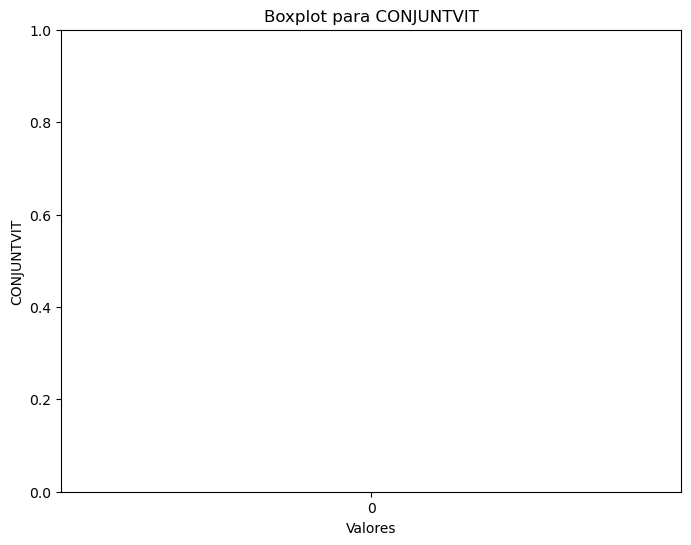

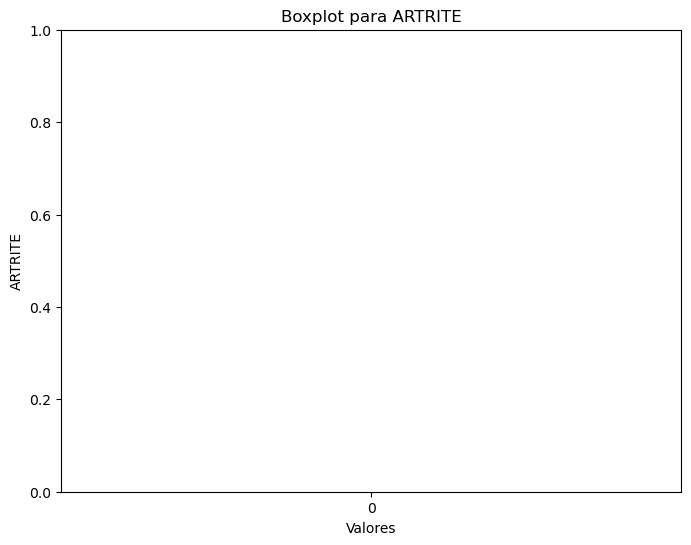

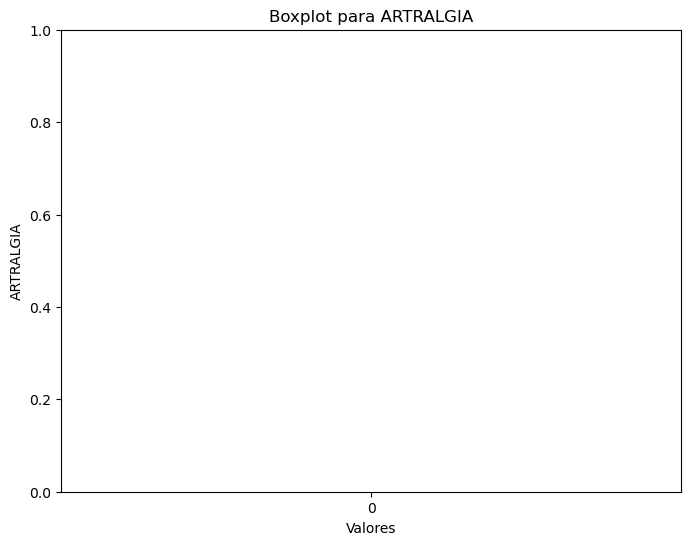

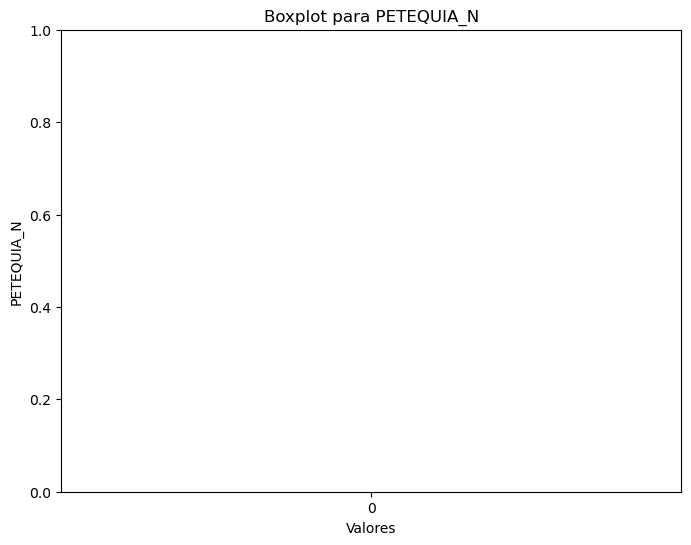

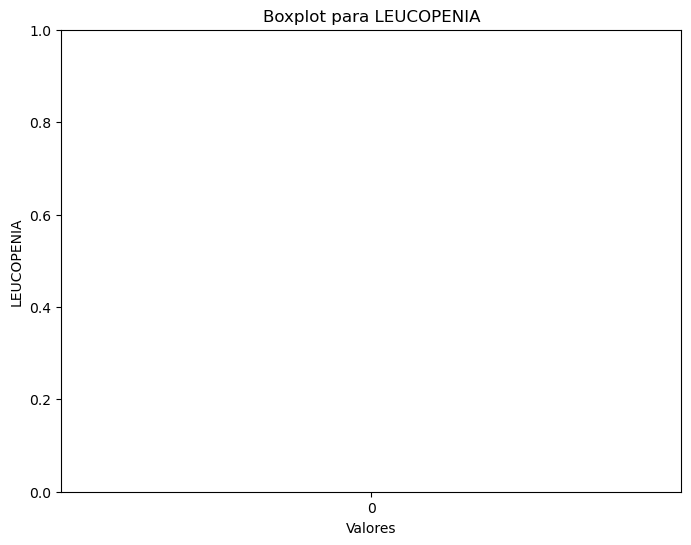

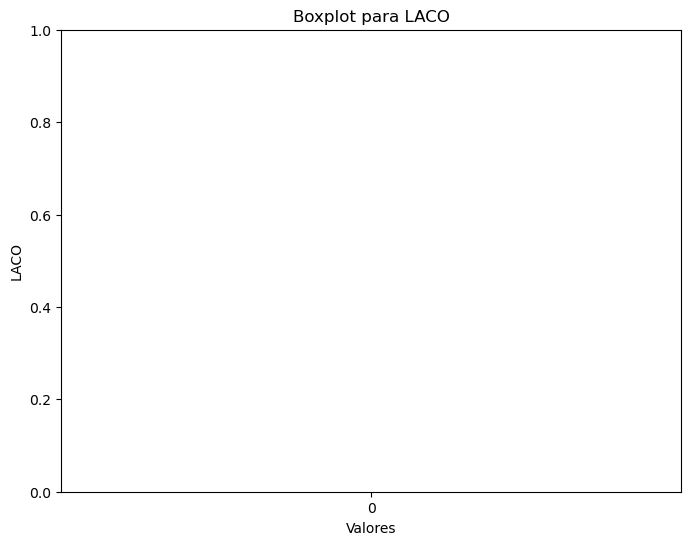

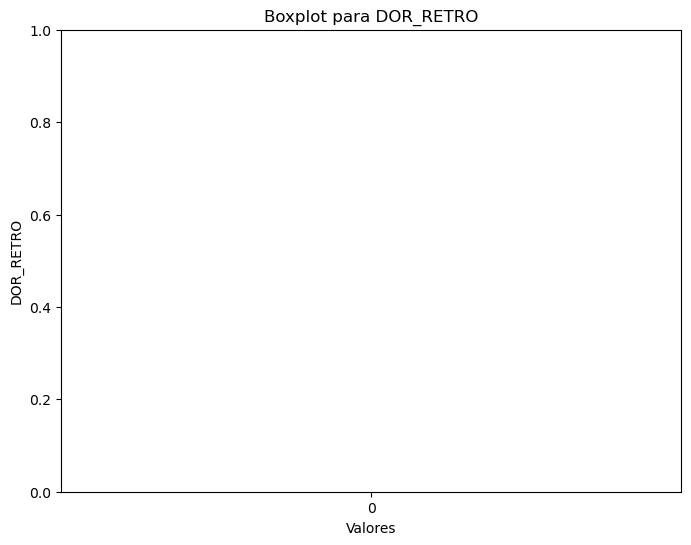

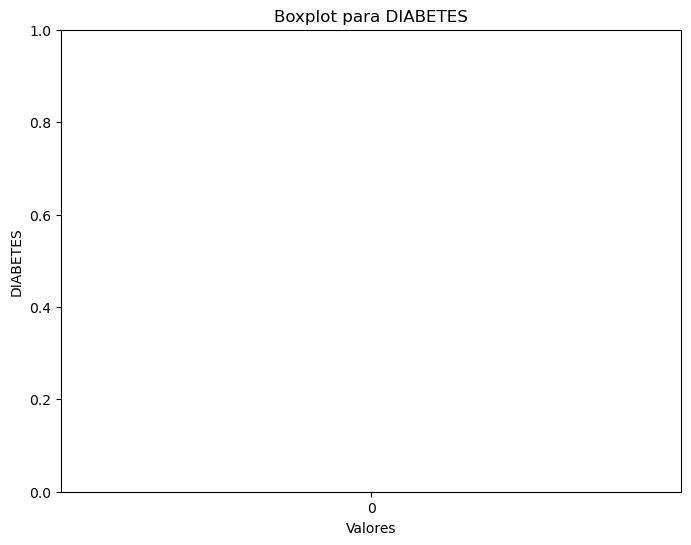

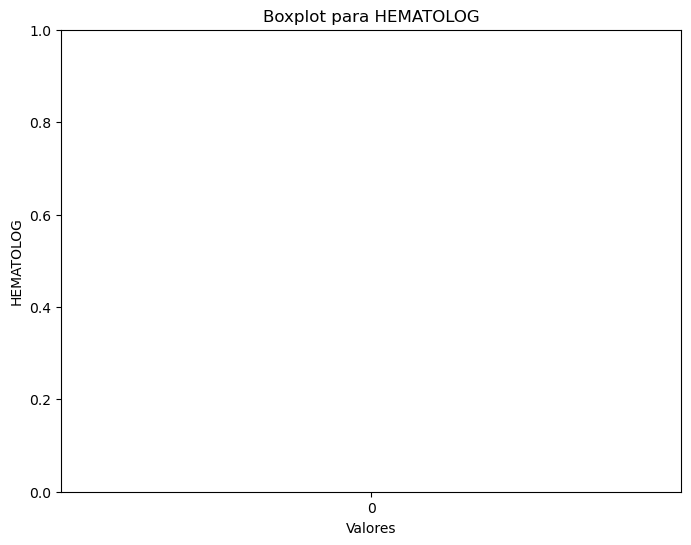

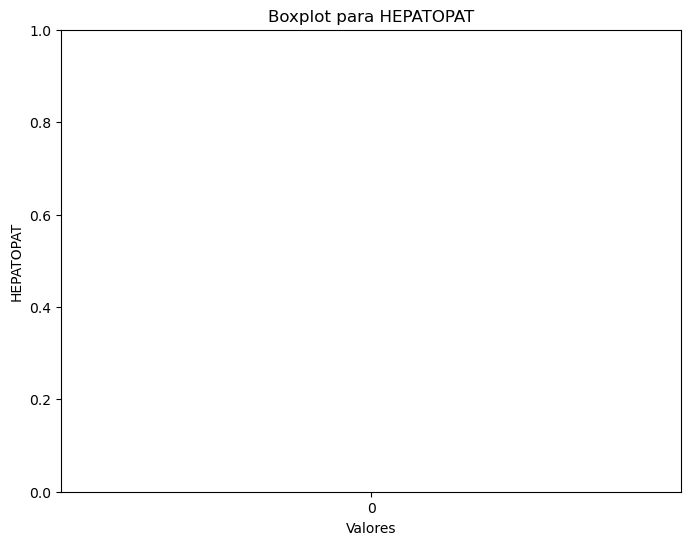

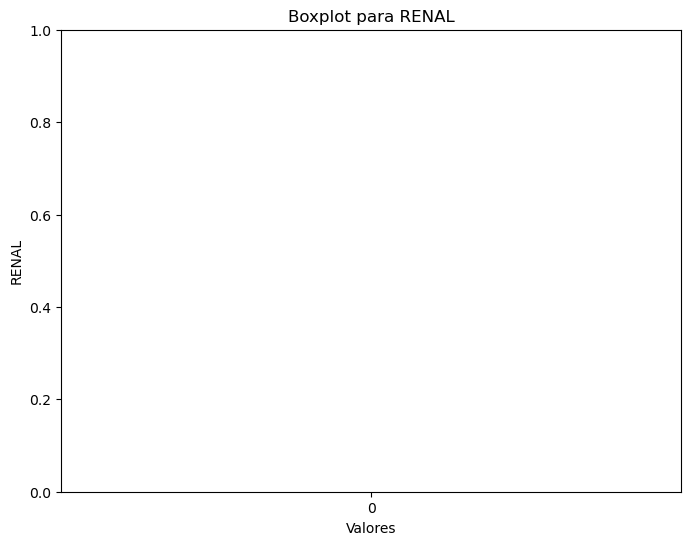

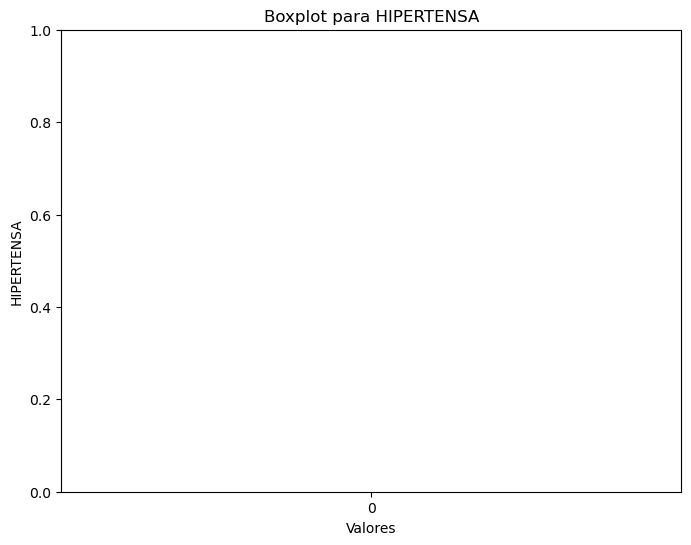

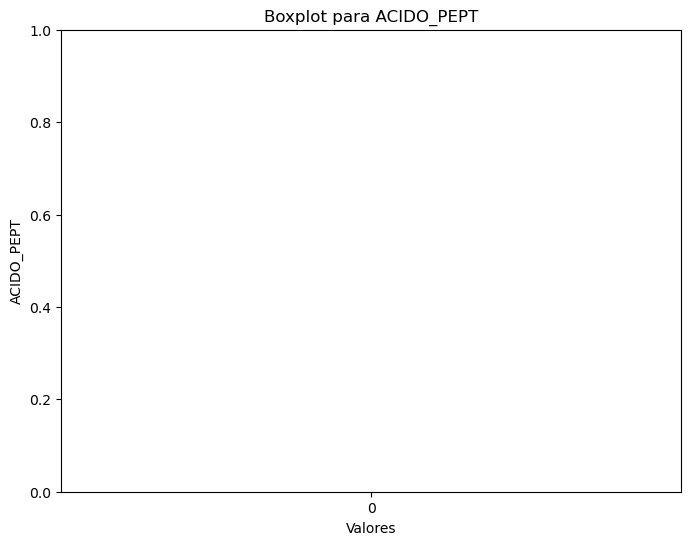

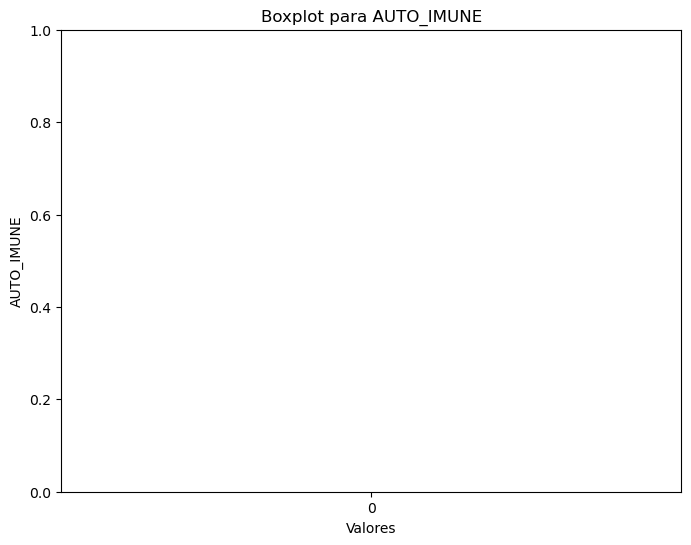

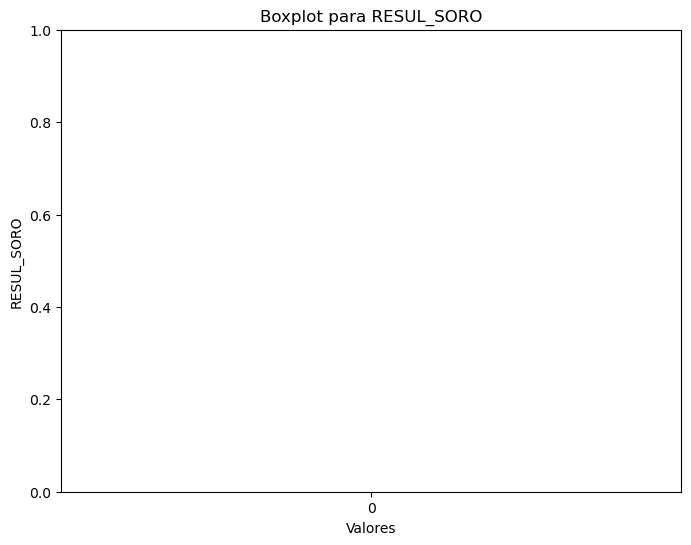

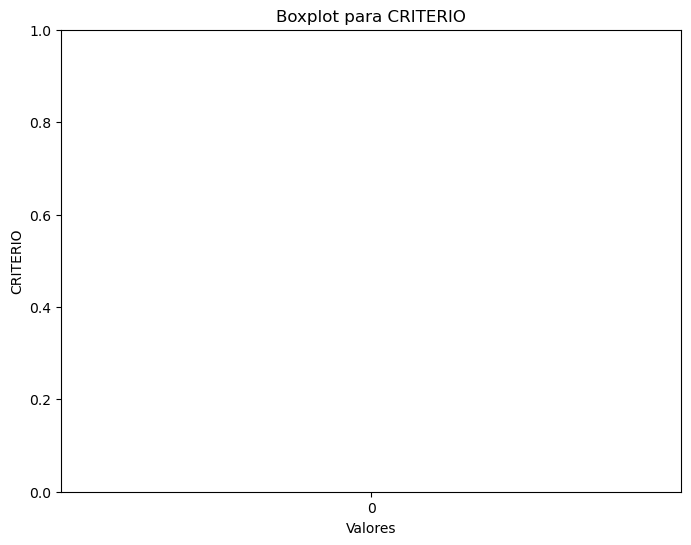

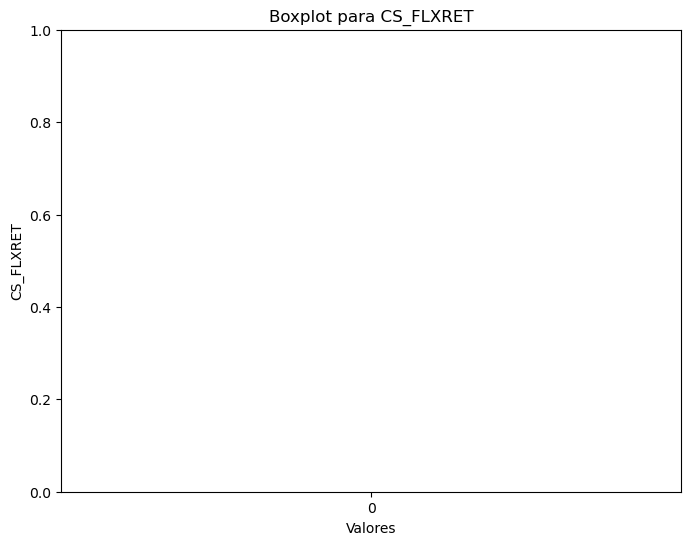

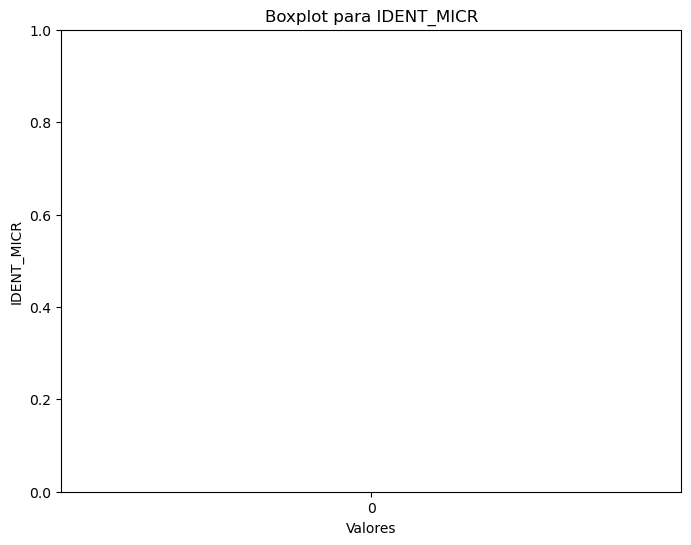

In [57]:
#Plotando boxplots após a normalização

for coluna in df_analisenumn:
    plt.figure(figsize=(8, 6))
    sns.boxplot(datan=X_train[coluna])
    plt.title('Boxplot para {}'.format(coluna))
    plt.xlabel('Valores')
    plt.ylabel('{}'.format(coluna))
    plt.show()

# 2. Algoritmos

In [59]:
# COmbinando os índices do target com os features
indices_presentes = X_train.index
y_train = y_train.loc[indices_presentes]

indices_teste_teste = X_teste.index
y_teste = y_teste.loc[indices_teste_teste]

indices_presentes_cv = X_cv.index
y_cv = y_cv.loc[indices_presentes_cv]

Melhor numero de vizinhos: {'n_neighbors': 15}
*********************************************
Acurácia 0.7393205016658532
Precisão: 0.7389706022569165
Recall: 0.739219149582293
F1-score: 0.7390472040901634


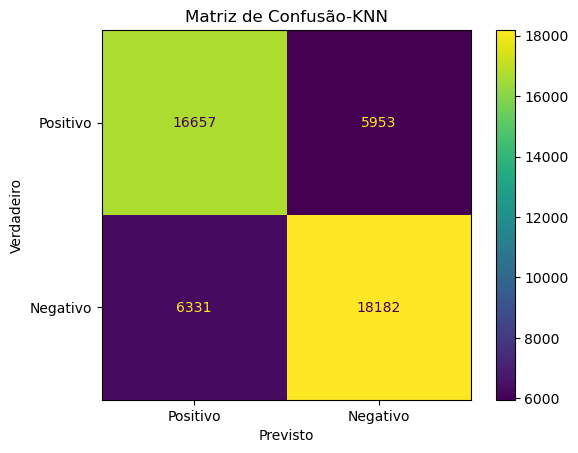

              precision    recall  f1-score   support

           0       0.72      0.74      0.73     22610
           1       0.75      0.74      0.75     24513

    accuracy                           0.74     47123
   macro avg       0.74      0.74      0.74     47123
weighted avg       0.74      0.74      0.74     47123



In [60]:
# K-Nearest Neighbors (KNN)
# Número de Vizinhos (K): Comece com K=5, podendo ser ajustado por meio de validação cruzada.
# Métrica de Distância: Euclidiana.
# Peso das amostras: Uniforme.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

parametros_knn = {'n_neighbors': range(1, 21)}

knn = KNeighborsClassifier(metric='euclidean', weights='uniform')

grid_search = GridSearchCV(knn, parametros_knn, cv=5)
grid_search.fit(X_cv, y_cv)
print('Melhor numero de vizinhos:', grid_search.best_params_)
print('*********************************************')

knn_final = KNeighborsClassifier(n_neighbors=13, metric='euclidean', weights='uniform')
knn_final.fit(X_train, y_train)

knn_pred = knn_final.predict(X_teste)
acurácia_knn = accuracy_score(y_teste, knn_pred)
p_knn = precision_score(y_teste, knn_pred, average='macro')
r_knn = recall_score(y_teste, knn_pred, average='macro')
f1_knn = f1_score(y_teste, knn_pred, average='macro')

print("Acurácia", acurácia_knn)
print("Precisão:", p_knn)
print("Recall:", r_knn)
print("F1-score:", f1_knn)

# Calcula a matriz de confusão KNN
cmKNN = confusion_matrix(y_teste, knn_pred)

# Define rótulos para os eixos
labels = ['Positivo', 'Negativo']

ConfusionMatrixDisplay(cmKNN, display_labels=labels).plot()
plt.grid(False)

# Adiciona eixos e title
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão-KNN")
plt.show()

# Printando as métricas de precision, recall e f1-score
print(classification_report(y_teste, knn_pred))


Profundidade máxima com melhor desempenho: {'max_depth': 13}
*********************************************
Acurácia 0.9135454024573987
Precisão: 0.9144095918080856
Recall: 0.9126814188241883
F1-score: 0.9132510395292506


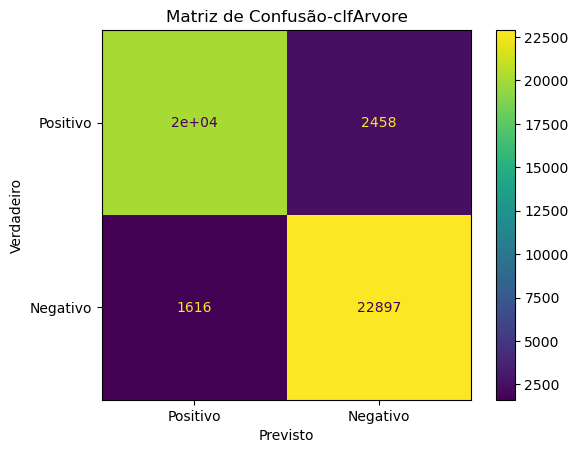

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     22610
           1       0.90      0.93      0.92     24513

    accuracy                           0.91     47123
   macro avg       0.91      0.91      0.91     47123
weighted avg       0.91      0.91      0.91     47123



In [61]:
# Árvore de Decisão
# Critério de Divisão: Entropia
# Profundidade Máxima: Sem limite inicial, ajustável com validação cruzada
# Número Mínimo de Amostras para Divisão de um Nó: 2.
# Número Mínimo de Amostras em um Nó Folha: 1

from sklearn import tree

parametros_clfArvore = {'max_depth': range(1, 21)}

clfArvore = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2, min_samples_leaf=1)

grid_searchclfA = GridSearchCV(clfArvore, parametros_clfArvore, cv=5)
grid_searchclfA.fit(X_cv, y_cv)
print('Profundidade máxima com melhor desempenho:', grid_searchclfA.best_params_)
print('*********************************************')

clfArvore_final = tree.DecisionTreeClassifier(max_depth = 12, criterion='entropy', min_samples_split=2, min_samples_leaf=1)
clfArvore_final.fit(X_train, y_train)

clfArvore_pred = clfArvore_final.predict(X_teste)
acurácia_clfArvore = accuracy_score(y_teste, clfArvore_pred)
p_clfArvore = precision_score(y_teste, clfArvore_pred, average='macro')
r_clfArvore = recall_score(y_teste, clfArvore_pred, average='macro')
f1_clfArvore = f1_score(y_teste, clfArvore_pred, average='macro')

print("Acurácia", acurácia_clfArvore)
print("Precisão:", p_clfArvore)
print("Recall:", r_clfArvore)
print("F1-score:", f1_clfArvore)

# Calcula a matriz de confusão clfArvore
cmclfArvore = confusion_matrix(y_teste, clfArvore_pred)

# Define rótulos para os eixos
labels = ['Positivo', 'Negativo']

ConfusionMatrixDisplay(cmclfArvore, display_labels=labels).plot()
plt.grid(False)

# Adiciona eixos e title
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão-clfArvore")
plt.show()

# Printando as métricas de precision, recall e f1-score
print(classification_report(y_teste, clfArvore_pred))


C:\Users\leand\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Acurácia 0.8815016021900134
Precisão: 0.8826483722665319
Recall: 0.880362094918161
F1-score: 0.8810177583267066


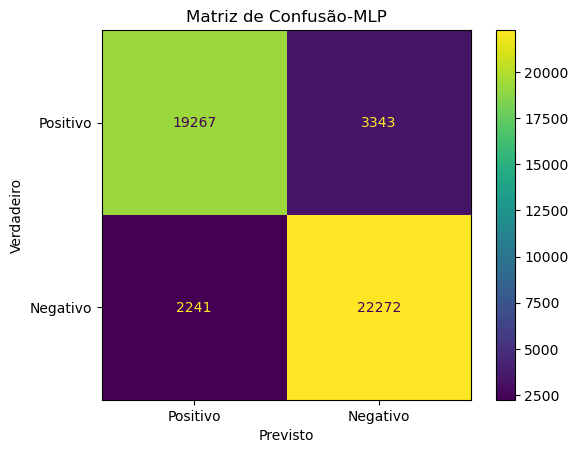

              precision    recall  f1-score   support

           0       0.90      0.85      0.87     22610
           1       0.87      0.91      0.89     24513

    accuracy                           0.88     47123
   macro avg       0.88      0.88      0.88     47123
weighted avg       0.88      0.88      0.88     47123



In [62]:
# Rede Neural (Multilayer Perceptron - MLP).
# Número de Camadas Ocultas: 2 camadas.
# Número de Neurônios em Cada Camada Oculta: 100 neurônios.
# Função de Ativação: ReLU.
# Solver (Algoritmo de Otimização): Adam.
# Taxa de Aprendizado: 0.001.
# Número de Épocas: 200.
# Tamanho do Lote: 32.

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=200, batch_size=32)

mlp.fit(X_train, y_train)

mlp_pred = mlp.predict(X_teste)
acurácia_mlp = accuracy_score(y_teste, mlp_pred)
p_mlp = precision_score(y_teste, mlp_pred, average='macro')
r_mlp = recall_score(y_teste, mlp_pred, average='macro')
f1_mlp = f1_score(y_teste, mlp_pred, average='macro')

print("Acurácia", acurácia_mlp)
print("Precisão:", p_mlp)
print("Recall:", r_mlp)
print("F1-score:", f1_mlp)


# Calcula a matriz de confusão MLP
cmmlp = confusion_matrix(y_teste, mlp_pred)

# Define rótulos para os eixos
labels = ['Positivo', 'Negativo']

ConfusionMatrixDisplay(cmmlp, display_labels=labels).plot()
plt.grid(False)

# Adiciona eixos e title
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão-MLP")
plt.show()

# Printando as métricas de precision, recall e f1-score
print(classification_report(y_teste, mlp_pred))

Acurácia 0.7336332576448867
Precisão: 0.7406806741458968
Recall: 0.7296032326707906
F1-score: 0.7291073195752978


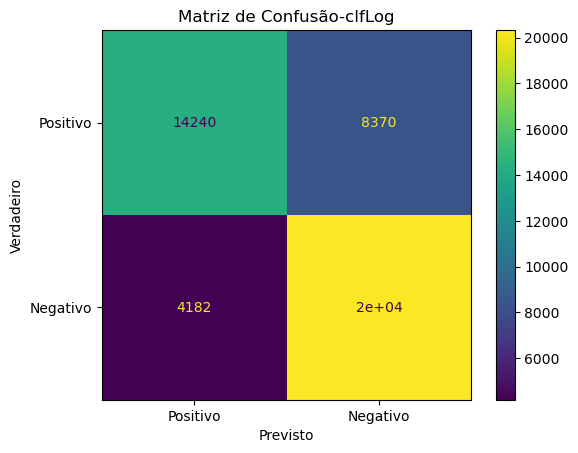

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     22610
           1       0.71      0.83      0.76     24513

    accuracy                           0.73     47123
   macro avg       0.74      0.73      0.73     47123
weighted avg       0.74      0.73      0.73     47123



In [63]:
# Logistic Regression (Regressão Logística).
# Solver: lbfgs.
# Penalidade: L2.
# Máximo de Iterações: 100.

from sklearn.linear_model import LogisticRegression

clfLog = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=100)

clfLog.fit(X_train, y_train)

clfLog_pred = clfLog.predict(X_teste)
acurácia_clfLog = accuracy_score(y_teste, clfLog_pred)
p_clfLog = precision_score(y_teste, clfLog_pred, average='macro')
r_clfLog = recall_score(y_teste, clfLog_pred, average='macro')
f1_clfLog = f1_score(y_teste, clfLog_pred, average='macro')

print("Acurácia", acurácia_clfLog)
print("Precisão:", p_clfLog)
print("Recall:", r_clfLog)
print("F1-score:", f1_clfLog)

# Calcula a matriz de confusão clfLog
cmclfLog = confusion_matrix(y_teste, clfLog_pred)

# Define rótulos para os eixos
labels = ['Positivo', 'Negativo']

ConfusionMatrixDisplay(cmclfLog, display_labels=labels).plot()
plt.grid(False)

# Adiciona eixos e title
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão-clfLog")
plt.show()

# Printando as métricas de precision, recall e f1-score
print(classification_report(y_teste, clfLog_pred))

Acurácia 0.9334295354710014
Precisão: 0.9338563958166237
Recall: 0.9328770075750543
F1-score: 0.9332535027715452


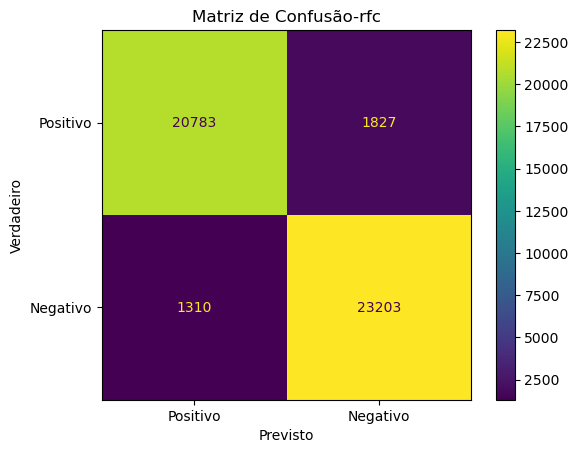

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     22610
           1       0.93      0.95      0.94     24513

    accuracy                           0.93     47123
   macro avg       0.93      0.93      0.93     47123
weighted avg       0.93      0.93      0.93     47123



In [83]:
# Random Forest (Floresta Aleatória).
# Número de Árvores na Floresta: 100
# Critério de Divisão: Entropia

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, criterion='entropy')

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_teste)
acurácia_rfc = accuracy_score(y_teste, rfc_pred)
p_rfc = precision_score(y_teste, rfc_pred, average='macro')
r_rfc = recall_score(y_teste, rfc_pred, average='macro')
f1_rfc = f1_score(y_teste, rfc_pred, average='macro')

print("Acurácia", acurácia_rfc)
print("Precisão:", p_rfc)
print("Recall:", r_rfc)
print("F1-score:", f1_rfc)

# Calcula a matriz de confusão rfc
cmrfc = confusion_matrix(y_teste, rfc_pred)

# Define rótulos para os eixos
labels = ['Positivo', 'Negativo']

ConfusionMatrixDisplay(cmrfc, display_labels=labels).plot()
plt.grid(False)

# Adiciona eixos e title
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão-rfc")
plt.show()

# Printando as métricas de precision, recall e f1-score
print(classification_report(y_teste, rfc_pred))

In [ ]:
pd.set_option('display.max_colwidth', 140)
scores = {
    'Algoritmo': ['KNN', 'Decision Tree', 'Rede Neural (MLP)', 'Regressão Logística', 'Random Forest'],
    'Acurácia': [acurácia_knn, acurácia_clfArvore, acurácia_mlp, acurácia_clfLog, acurácia_rfc],
    'Precisão': [p_knn, p_clfArvore, p_mlp, p_clfLog, p_rfc],
    'Recall': [r_knn, r_clfArvore, r_mlp, r_clfLog, r_rfc],
    'F1-score': [f1_knn, f1_clfArvore, f1_mlp, f1_clfLog, f1_rfc],
    'Parametros': [{'n_neighbors': knn_final.n_neighbors, 'metric': knn_final.metric, 'weights': knn_final.weights}, {'criterion': clfArvore_final.criterion, 'max_depth': clfArvore_final.max_depth, 'min_samples_split': clfArvore_final.min_samples_split, 'min_samples_leaf': clfArvore_final.min_samples_leaf}, {'hidden_layer_sizes': mlp.hidden_layer_sizes, 'activation': mlp.activation, 'solver':mlp.solver, 'learning_rate_init': mlp.learning_rate_init, 'max_iter': mlp.max_iter, 'batch_size': mlp.batch_size}, {'solver': clfLog.solver, 'penalty': clfLog.penalty, 'max_iter': clfLog.max_iter}, {'n_estimators': rfc.n_estimators, 'criterion': rfc.criterion}],
    
}

metricas = pd.DataFrame(scores)
metricas.to_csv("metricas.csv", index=False)
display(metricas)
pd.reset_option('^display.', silent=True)

## Ajuste de hiperparêmetros

In [85]:
import os

if os.path.exists ("metricas_ajustadas.csv"):
    metricas_ajustadas = pd.read_csv("metricas_ajustadas.csv")   
else:
   metricas_ajustadas = pd.DataFrame(columns=['Algoritmo', 'Acurácia', 'Precisão', 'Recall', 'F1-score', 'Parametros'])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# K-Nearest Neighbors (KNN)

parametros_knn = {'n_neighbors': range(5, 1000), 'metric': ['minkowski', 'euclidean', 'manhattan', 'cityblock', 'cosine', '/l1', 'l2', 'nan_euclidean'], 'weights': ['uniform', 'distance']}

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')

ramdom_searchknn = RandomizedSearchCV(knn, parametros_knn, n_iter=10, cv=5)
ramdom_searchknn.fit(X_cv, y_cv)
melhores_parametrosknn = ramdom_searchknn.best_params_
print('Melhor numero de vizinhos:', melhores_parametrosknn['n_neighbors'], 'Melhor métrica de distância:', melhores_parametrosknn['metric'], 'Melhor peso das amostras:', melhores_parametrosknn['weights'])
print('*********************************************')

n_neighbors= melhores_parametrosknn['n_neighbors']
metric = melhores_parametrosknn['metric']
weights = melhores_parametrosknn['weights']
knn_final = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
knn_final.fit(X_train, y_train)

knn_pred = knn_final.predict(X_teste)
acurácia_knn = accuracy_score(y_teste, knn_pred)
p_knn = precision_score(y_teste, knn_pred, average='macro')
r_knn = recall_score(y_teste, knn_pred, average='macro')
f1_knn = f1_score(y_teste, knn_pred, average='macro')

print("Acurácia", acurácia_knn)
print("Precisão:", p_knn)
print("Recall:", r_knn)
print("F1-score:", f1_knn)

linha_metricasknn = pd.DataFrame([{'Algoritmo': 'KNN', 'Acurácia': acurácia_knn, 'Precisão': p_knn, 'Recall': r_knn, 'F1-score': f1_knn, 'Parametros': {'n_neighbors': knn_final.n_neighbors, 'metric': knn_final.metric, 'weights': knn_final.weights}}])
metricas_ajustadas = pd.concat([metricas_ajustadas, linha_metricasknn], ignore_index=True)
#metricas_ajustadas = metricas_ajustadas.drop_duplicates()
metricas_ajustadas.to_csv("metricas_ajustadas.csv", index=False)

In [ ]:
# Árvore de Decisão

parametros_clfArvore = {'max_depth': range(1, 100), 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': range(1, 100), 'min_samples_leaf': range(1, 100)}

clfArvore = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2, min_samples_leaf=1)

random_searchclfArvore = RandomizedSearchCV(clfArvore, parametros_clfArvore, n_iter=10, cv=5)
random_searchclfArvore.fit(X_cv, y_cv)
melhores_parametrosclfArvore = random_searchclfArvore.best_params_
print('Parametros com melhor desempeno:', 'Profundidade máxima:', melhores_parametrosclfArvore['max_depth'], 'Critério de Divisão:', melhores_parametrosclfArvore['criterion'], 'Número Mínimo de Amostras para Divisão de um Nó:', melhores_parametrosclfArvore['min_samples_split'], 'Número Mínimo de Amostras em um Nó Folha:', melhores_parametrosclfArvore['min_samples_leaf'])
print('*********************************************')

max_depth = melhores_parametrosclfArvore['max_depth']
criterion = melhores_parametrosclfArvore['criterion']
min_samples_split = melhores_parametrosclfArvore['min_samples_split']
min_samples_leaf = melhores_parametrosclfArvore['min_samples_leaf']

clfArvore_final = tree.DecisionTreeClassifier(max_depth = max_depth, criterion=criterion, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
clfArvore_final.fit(X_train, y_train)

clfArvore_pred = clfArvore_final.predict(X_teste)
acurácia_clfArvore = accuracy_score(y_teste, clfArvore_pred)
p_clfArvore = precision_score(y_teste, clfArvore_pred, average='macro')
r_clfArvore = recall_score(y_teste, clfArvore_pred, average='macro')
f1_clfArvore = f1_score(y_teste, clfArvore_pred, average='macro')

print("Acurácia", acurácia_clfArvore)
print("Precisão:", p_clfArvore)
print("Recall:", r_clfArvore)
print("F1-score:", f1_clfArvore)

linha_metricasclfArvore = pd.DataFrame([{'Algoritmo': 'Decision Tree', 'Acurácia': acurácia_clfArvore, 'Precisão': p_clfArvore, 'Recall': r_clfArvore, 'F1-score': f1_clfArvore, 'Parametros': {'max_depth': clfArvore_final.max_depth, 'criterion': clfArvore_final.criterion, 'min_samples_split': clfArvore_final.min_samples_split, 'min_samples_leaf': clfArvore_final.min_samples_leaf}}])
metricas_ajustadas = pd.concat([metricas_ajustadas, linha_metricasclfArvore], ignore_index=True)
#metricas_ajustadas = metricas_ajustadas.drop_duplicates()
metricas_ajustadas.to_csv("metricas_ajustadas.csv", index=False)

In [ ]:
# Rede Neural (Multilayer Perceptron - MLP).

parametros_mlp = {'hidden_layer_sizes': [(50, 50), (100, 100), (50,50,50), (50,100,50), (200, 200), (300, 300), (200, 200, 200)], 'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam'], 'learning_rate_init': [0.001, 0.002, 0.005, 0.007, 0.009, 0.01, 0.05, 0.08, 0.1, 0.5, 0.8, 1.0], 'max_iter': range(100, 1000), 'batch_size': range(1, 100)} 

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=200, batch_size=32)

random_searchmlp = RandomizedSearchCV(mlp, parametros_mlp, n_iter=10, cv=5)
random_searchmlp.fit(X_cv, y_cv)
melhores_parametrosmlp = random_searchmlp.best_params_
print('Parametros com melhor resultado:', 'hidden_layer_sizes:', melhores_parametrosmlp['hidden_layer_sizes'], 'activation:', melhores_parametrosmlp['activation'], 'solver:', melhores_parametrosmlp['solver'], 'learning_rate_init:', melhores_parametrosmlp['learning_rate_init'], 'max_iter:', melhores_parametrosmlp['max_iter'], 'batch_size:', melhores_parametrosmlp['batch_size'])
print('*********************************************')

hidden_layer_sizes = melhores_parametrosmlp['hidden_layer_sizes']
activation = melhores_parametrosmlp['activation']
solver = melhores_parametrosmlp['solver']
learning_rate_init = melhores_parametrosmlp['learning_rate_init']
max_iter = melhores_parametrosmlp['max_iter']
batch_size = melhores_parametrosmlp['batch_size']

mlp_final = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, learning_rate_init=learning_rate_init, max_iter=max_iter, batch_size=batch_size)
mlp_final.fit(X_train, y_train)

mlp_pred = mlp_final.predict(X_teste)
acurácia_mlp = accuracy_score(y_teste, mlp_pred)
p_mlp = precision_score(y_teste, mlp_pred, average='macro')
r_mlp = recall_score(y_teste, mlp_pred, average='macro')
f1_mlp = f1_score(y_teste, mlp_pred, average='macro')

print("Acurácia", acurácia_mlp)
print("Precisão:", p_mlp)
print("Recall:", r_mlp)
print("F1-score:", f1_mlp)

linha_metricasmlp = pd.DataFrame([{'Algoritmo': 'Rede Neural (MLP)', 'Acurácia': acurácia_mlp, 'Precisão': p_mlp, 'Recall': r_mlp, 'F1-score': f1_mlp, 'Parametros': {'hidden_layer_sizes': mlp_final.hidden_layer_sizes, 'activation': mlp_final.activation, 'solver': mlp_final.solver, 'learning_rate_init': mlp_final.learning_rate_init, 'max_iter': mlp_final.max_iter, 'batch_size': mlp_final.batch_size}}])
metricas_ajustadas = pd.concat([metricas_ajustadas, linha_metricasmlp], ignore_index=True)
#metricas_ajustadas = metricas_ajustadas.drop_duplicates()
metricas_ajustadas.to_csv("metricas_ajustadas.csv", index=False)

In [ ]:
# Logistic Regression (Regressão Logística).

parametros_clfLog = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'saga'], 'penalty':['l1', 'l2', 'elasticnet', None], 'max_iter': range(1, 100)} 

clfLog = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=100)

random_searchclfLog = RandomizedSearchCV(clfLog, parametros_clfLog, n_iter=10, cv=5)
random_searchclfLog.fit(X_cv, y_cv)
melhores_parametrosclfLog = random_searchclfLog.best_params_
print('Parametros com melhor resultado:', 'solver:', melhores_parametrosclfLog['solver'], 'penalty:', melhores_parametrosclfLog['penalty'], 'max_iter:', melhores_parametrosclfLog['max_iter'])
print('*********************************************')

solver = melhores_parametrosclfLog['solver']
penalty = melhores_parametrosclfLog['penalty']
max_iter = melhores_parametrosclfLog['max_iter']
clfLog_final = LogisticRegression(solver=solver, penalty=penalty, max_iter=max_iter)
clfLog_final.fit(X_train, y_train)

clfLog_pred = clfLog_final.predict(X_teste)
acurácia_clfLog = accuracy_score(y_teste, clfLog_pred)
p_clfLog = precision_score(y_teste, clfLog_pred, average='macro')
r_clfLog = recall_score(y_teste, clfLog_pred, average='macro')
f1_clfLog = f1_score(y_teste, clfLog_pred, average='macro')

print("Acurácia", acurácia_clfLog)
print("Precisão:", p_clfLog)
print("Recall:", r_clfLog)
print("F1-score:", f1_clfLog)

linha_metricasclfLog = pd.DataFrame([{'Algoritmo': 'Regressão Logística', 'Acurácia': acurácia_clfLog, 'Precisão': p_clfLog, 'Recall': r_clfLog, 'F1-score': f1_clfLog, 'Parametros': {'solver': clfLog_final.solver, 'penalty': clfLog_final.penalty, 'max_iter': clfLog_final.max_iter}}])
metricas_ajustadas = pd.concat([metricas_ajustadas, linha_metricasclfLog], ignore_index=True)
#metricas_ajustadas = metricas_ajustadas.drop_duplicates()
metricas_ajustadas.to_csv("metricas_ajustadas.csv", index=False)

In [ ]:
# Random Forest (Floresta Aleatória).

parametros_rfc = {'n_estimators': range(1, 1000), 'criterion':['gini', 'entropy', 'log_loss']} 

rfc = RandomForestClassifier(n_estimators=100, criterion='entropy')

random_searchrfc = RandomizedSearchCV(rfc, parametros_rfc, n_iter=10, cv=5)
random_searchrfc.fit(X_cv, y_cv)
melhores_parametrosrfc = random_searchrfc.best_params_
print('Parametros com melhor resultado:', 'n_estimators:', melhores_parametrosrfc['n_estimators'], 'criterion:', melhores_parametrosrfc['criterion'])
print('*********************************************')

n_estimators = melhores_parametrosrfc['n_estimators']
criterion = melhores_parametrosrfc['criterion']
rfc_final = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
rfc_final.fit(X_train, y_train)

rfc_pred = rfc_final.predict(X_teste)
acurácia_rfc = accuracy_score(y_teste, rfc_pred)
p_rfc = precision_score(y_teste, rfc_pred, average='macro')
r_rfc = recall_score(y_teste, rfc_pred, average='macro')
f1_rfc = f1_score(y_teste, rfc_pred, average='macro')

print("Acurácia", acurácia_rfc)
print("Precisão:", p_rfc)
print("Recall:", r_rfc)
print("F1-score:", f1_rfc)

linha_metricasrfc = pd.DataFrame([{'Algoritmo': 'Random Forest', 'Acurácia': acurácia_rfc, 'Precisão': p_rfc, 'Recall': r_rfc, 'F1-score': f1_rfc, 'Parametros': {'n_estimators': rfc_final.n_estimators, 'criterion': rfc_final.criterion}}])
metricas_ajustadas = pd.concat([metricas_ajustadas, linha_metricasrfc], ignore_index=True)
#metricas_ajustadas = metricas_ajustadas.drop_duplicates()
metricas_ajustadas.to_csv("metricas_ajustadas.csv", index=False)

In [79]:
# exibe os scores após o ajuste dos hiperparâmetros

pd.set_option('display.max_colwidth', 140)

metricas_ajustadas = pd.read_csv("metricas_ajustadas.csv")

display(metricas_ajustadas)

pd.reset_option('^display.', silent=True)

,Algoritmo,Acurácia,Precisão,Recall,F1-score,Parametros
0,KNN,0.861043,0.861983,0.859868,0.860473,"{'n_neighbors': 20, 'metric': 'manhattan', 'weights': 'distance'}"
1,KNN,0.861086,0.862052,0.859898,0.860510,"{'n_neighbors': 21, 'metric': 'manhattan', 'weights': 'distance'}"
2,Decision Tree,0.945247,0.945750,0.944687,0.945096,"{'max_depth': 11, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 5}"
3,KNN,0.860447,0.861134,0.859399,0.859929,"{'n_neighbors': 13, 'metric': 'manhattan', 'weights': 'distance'}"
4,KNN,0.861703,0.862807,0.860454,0.861102,"{'n_neighbors': 24, 'metric': 'cityblock', 'weights': 'distance'}"
5,Decision Tree,0.945843,0.946190,0.945379,0.945706,"{'max_depth': 12, 'criterion': 'entropy', 'min_samples_split': 2, 'min_samples_leaf': 3}"
6,Rede Neural (MLP),0.925883,0.926275,0.925309,0.925682,"{'hidden_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'solver': 'lbfgs', 'learning_rate_init': 0.01, 'max_iter': 200, 'batch_size':..."
7,Regressão Logística,0.735407,0.742825,0.731229,0.730740,"{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200}"
8,Random Forest,0.958951,0.959618,0.958358,0.958832,"{'n_estimators': 450, 'criterion': 'gini'}"
9,KNN,0.860341,0.861064,0.859272,0.859814,"{'n_neighbors': 15, 'metric': 'cityblock', 'weights': 'distance'}"


# Curva ROC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# gerando uma baseline
baseline = [0 for _ in range(len(y_teste))]

# prevendo as probabilidades
knn_probs = knn_final.predict_proba(X_teste)[:, 1]
clfArvore_probs = clfArvore_final.predict_proba(X_teste)[:, 1]
mlp_probs = mlp_final.predict_proba(X_teste)[:, 1]
clfLog_probs = clfLog_final.predict_proba(X_teste)[:, 1]
rfc_probs = rfc_final.predict_proba(X_teste)[:, 1]

# calculando os scores
baseline_auc = roc_auc_score(y_teste, baseline)

knn_auc = roc_auc_score(y_teste, knn_probs)
clfArvore_auc = roc_auc_score(y_teste, clfArvore_probs)
mlp_auc = roc_auc_score(y_teste, mlp_probs)
clfLog_auc = roc_auc_score(y_teste, clfLog_probs)
rfc_auc = roc_auc_score(y_teste, rfc_probs)

# printando os scores AUC
print(f'Baseline: ROC AUC = {baseline_auc :.3f}')
print(f'KNN: ROC AUC = {knn_auc :.3f}')
print(f'Árvore de Decisão: ROC AUC = {clfArvore_auc :.3f}')
print(f'Rede Neural (MLP): ROC AUC = {mlp_auc :.3f}')
print(f'Regressão Logística: ROC AUC = {clfLog_auc :.3f}')
print(f'Random Forest: ROC AUC = {rfc_auc :.3f}')

# calculando a curva ROC
base_fpr, base_tpr, _ = roc_curve(y_teste, baseline)
knn_fpr, knn_tpr, _ = roc_curve(y_teste, knn_probs)
clfArvore_fpr, clfArvore_tpr, _ = roc_curve(y_teste, clfArvore_probs)
mlp_fpr, mlp_tpr, _ = roc_curve(y_teste, mlp_probs)
clfLog_fpr, clfLog_tpr, _ = roc_curve(y_teste, clfLog_probs)
rfc_fpr, rfc_tpr, _ = roc_curve(y_teste, rfc_probs)

# configurando a área de plotagem
plt.figure(figsize=(8, 6))

# plotando a curva ROC
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(knn_fpr, knn_tpr, linestyle='-', label='KNN')
plt.plot(clfArvore_fpr, clfArvore_tpr, linestyle='-', label='Árvore de Decisão')
plt.plot(mlp_fpr, mlp_tpr, linestyle='-', label='Rede Neural (MLP)')
plt.plot(clfLog_fpr, clfLog_tpr, linestyle='-', label='Regressão Logística')
plt.plot(rfc_fpr, rfc_tpr, linestyle='-', label='Random Forest')

# rotulando os eixos
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

# inserindo o titulo
plt.title('Curva ROC', fontsize=20)

# mostrando a legenda
plt.legend()

# plotando
plt.show()